In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, InsetPosition, mark_inset
from matplotlib.legend_handler import HandlerTuple
%run config_10.py

Figures saved at figures/Output20_05_10_80_80_500_80_1_123456
Simulations saved at data/Sims20_05_10_80_80_500_80_1_123456


In [2]:
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': r"\usepackage{amsmath}\usepackage{upgreek}"})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 20})

In [3]:
nBins = 30
nContourLevels = 3

# 2d contour levels: 
from scipy.stats import norm, chi2
levels = [norm.cdf(1)-norm.cdf(-1), norm.cdf(2)-norm.cdf(-2), norm.cdf(3)-norm.cdf(-3)] #[68%, 95.4%, 99.7%]
confLevels = [2*(1-norm.cdf(1)), 2*(1-norm.cdf(2)), 2*(1-norm.cdf(3))] #[.3173, .0455, .0027]
confLevels_grid = [-chi2.ppf(levels[2],df=2)/2, -chi2.ppf(levels[1],df=2)/2, -chi2.ppf(levels[0],df=2)/2, 0] #[-11.8/2,-6.17/2,-2.30/2,0]

smoothingKernel = 1
filledPlots = True
truthColors = np.expand_dims(np.array('black'), axis=0)
truthLineStyles = np.expand_dims(np.array('--'), axis=0)
plotDensity = False
figureWidth = 8

colorsDict = {
              # Match pygtc up to v0.2.4
              'blues_old' : ('#4c72b0','#7fa5e3','#b2d8ff'),
              'greens_old' : ('#55a868','#88db9b','#bbffce'),
              'yellows_old' : ('#f5964f','#ffc982','#fffcb5'),
              'reds_old' : ('#c44e52','#f78185','#ffb4b8'),
              'purples_old' : ('#8172b2','#b4a5e5','#37d8ff'),
              # New color scheme, dark colors match matplotlib v2
              'blues' : ('#1f77b4','#52aae7','#85ddff'),
              'oranges' : ('#ff7f0e','#ffb241','#ffe574'),
              'greens' : ('#2ca02c','#5fd35f','#92ff92'),
              'reds' : ('#d62728','#ff5a5b','#ff8d8e'),
              'purples' : ('#9467bd','#c79af0','#facdff'),
              'browns' : ('#8c564b','#bf897e','#f2bcb1'),
              'pinks' : ('#e377c2','#ffaaf5','#ffddff'),
              'grays' : ('#7f7f7f','#b2b2b2','#e5e5e5'),
              'yellows' : ('#bcbd22','#eff055','#ffff88'),
              'cyans' : ('#17becf','#4af1ff','#7dffff'),
          }
defaultColorsOrder = ['blues', 'oranges','greens', 'reds', 'purples',
                    'browns', 'pinks', 'grays', 'yellows', 'cyans']
colorsOrder = defaultColorsOrder
colors = [colorsDict[cs] for cs in colorsOrder]

def CustomCmap(to_rgb):
    import matplotlib.colors as mplcolors
    from matplotlib.colors import LinearSegmentedColormap
    # from color r,g,b
    r1,g1,b1 = 1,1,1
    # to color r,g,b
    r2,g2,b2 = mplcolors.hex2color(to_rgb)

    cdict = {'red': ((0, r1, r1), (1, r2, r2)),
           'green': ((0, g1, g1), (1, g2, g2)),
           'blue': ((0, b1, b1), (1, b2, b2))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

def setCustomColorMaps(colors):
    customColorMaps = [CustomCmap(color[0]) for color in colors]
    return customColorMaps

myColorMap = setCustomColorMaps(colors)

def plot2d(ax, nChains, chains2d, weights, nBins, smoothingKernel,
            filledPlots, colors, nContourLevels, confLevels, truths2d,
            truthColors, truthLineStyles, plotDensity, myColorMap):
    import scipy.ndimage
    
    # Empty arrays needed below
    chainLevels = np.ones((nChains,nContourLevels+1))
    extents = np.empty((nChains,4))

    # These are needed to compute the contour levels
    nBinsFlat = np.linspace(0., nBins**2, nBins**2)

    ##### The filled contour plots
    plotData = []
    # Draw filled contours in reversed order to have first chain in list on top
    for k in reversed(range(nChains)):
        # Is there a chain to plot?
        if (np.isnan(chains2d[k][0]).all())|(np.isnan(chains2d[k][1]).all()):
            plotData.append(None)
        else:
            # Create 2d histogram
            hist2d, xedges, yedges = np.histogram2d(
                chains2d[k][0], chains2d[k][1], weights=weights[k], bins=nBins)
            # image extent, needed below for contour lines
            extents[k] = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
            # Normalize
            hist2d = hist2d/np.sum(hist2d)
            # Cumulative 1d distribution
            histOrdered = np.sort(hist2d.flat)
            histCumulative = np.cumsum(histOrdered)

            # Compute contour levels (from low to high for technical reasons)
            for l in range(nContourLevels):
                # Find location of contour level in 1d histCumulative
                temp = np.interp(confLevels[l], histCumulative, nBinsFlat)
                # Find "height" of contour level
                chainLevels[k][nContourLevels-1-l] = np.interp(temp, nBinsFlat, histOrdered)

            # Apply Gaussian smoothing and plot filled contours if requested
            if smoothingKernel>0:
                plotData.append( scipy.ndimage.gaussian_filter(hist2d.T, sigma=smoothingKernel) )
            else:
                plotData.append( hist2d.T )
            if filledPlots:
                xbins = (xedges[1:]+xedges[:-1])/2
                ybins = (yedges[1:]+yedges[:-1])/2
                ax.contourf(xbins, ybins, plotData[-1], levels=chainLevels[k],
                    colors=colors[k][:nContourLevels][::-1])

            # Plot density
            if plotDensity:
                if filledPlots:
                    ax.imshow(hist2d.T, extent=extents[k], origin='lower',
                        cmap=myColorMap[k], aspect='auto', clim=(0,chainLevels[k][0]))
                else:
                    ax.imshow(hist2d.T, extent=extents[k], origin='lower',
                        cmap=myColorMap[k], aspect='auto')


    ###### Draw contour lines in order to see contours lying on top of each other
    for k in range(nChains):
        if plotData[nChains-1-k] is not None:
            for l in range(nContourLevels):
                ax.contour(plotData[nChains-1-k], [chainLevels[k][nContourLevels-1-l]],
                    extent=extents[k], origin='lower', linewidths=1, colors=colors[k][l])

    ##### Truth lines
    if truths2d is not None:
        for k in range(len(truths2d)):
            # horizontal line
            if truths2d[k][0] is not None:
                ax.axhline(truths2d[k][0], lw=1, color=truthColors[k], ls=truthLineStyles[k])
            # vertical line
            if truths2d[k][1] is not None:
                ax.axvline(truths2d[k][1], lw=1, color=truthColors[k], ls=truthLineStyles[k])

    return ax

In [4]:
## Load data ##
# ----------- #

lognormfields=np.load(simsout+'.npy')
T=np.load(dataout+'_mean_cov_theory.npz')
average_r, mean2pt, cov, xiLN = T['average_r'], T['mean2pt'], T['cov'], T['xiLN']
dxiLN_dalpha, dxiLN_dbeta = T['dxiLN_dalpha'], T['dxiLN_dbeta']

nfields = 4

# Simulation pool
P=np.load(dataout+'_sbi_pool.npz')
alpha_pool, beta_pool, comp_pool = P['alpha_pool'], P['beta_pool'], P['comp_pool']

# 2PCF, simulation-based inference
sample_size, alpha_marginal_stds, beta_marginal_stds = {}, {}, {}
sbi_samples, sbi_weights, disc_samples = {}, {}, {}
alpha_samples, beta_samples = {}, {}

for f in range(nfields):
    A=np.load(dataout+'_sbi_field'+str(f)+'.npz')
    epsilons, sample_size[f], alpha_marginal_stds[f], beta_marginal_stds[f] = \
        A['epsilons'], A['sample_size'], A['alpha_marginal_stds'], A['beta_marginal_stds']
    
    for epsilon in epsilons:
        AA=np.load(dataout+'_sbi_field'+str(f)+'_eps'+str(int(100*epsilon))+'_samples_posterior.npz')
        sbi_samples[f,epsilon], sbi_weights[f,epsilon], disc_samples[f,epsilon] = AA['samples'], AA['weights'], AA['disc']
        alpha_samples[f,epsilon], beta_samples[f,epsilon] = sbi_samples[f,epsilon].T[0], sbi_samples[f,epsilon].T[1]

sbi_lnL0, sbi_lnL1, sbi_lnL2, sbi_lnL3, sbi_lnL = {}, {}, {}, {}, {}
for epsilon in epsilons:
    with np.load(dataout+'_sbi_eps'+str(int(100*epsilon))+'_'+str(nfields)+'fields.npz') as C:
        sbi_lnL0[epsilon] = C['lnL0']
        sbi_lnL1[epsilon] = C['lnL1']
        sbi_lnL2[epsilon] = C['lnL2']
        sbi_lnL3[epsilon] = C['lnL3']
        sbi_lnL[epsilon] = C['lnL']
        alphas_sbi, betas_sbi = C['alphas'], C['betas']

# 2PCF, likelihood-based analysis
with np.load(dataout+'_summaries_'+str(nfields)+'fields.npz') as B:
    alphas_sum, betas_sum, sum_lnL0, sum_lnL1, sum_lnL2, sum_lnL3, sum_lnL =\
        B['alphas'], B['betas'], B['lnL0'], B['lnL1'], B['lnL2'], B['lnL3'], B['lnL']

# CW probes, simulation-based inference
tweb_lnL0, tweb_lnL1, tweb_lnL2, tweb_lnL3, tweb_lnL = {}, {}, {}, {}, {}
for epsilon_tweb in epsilons:
    with np.load(dataout+'_sbi_tweb_eps'+str(int(100*epsilon_tweb))+'_'+str(nfields)+'fields.npz') as C1:
        alphas_tweb, betas_tweb, tweb_lnL0[epsilon_tweb], tweb_lnL1[epsilon_tweb], tweb_lnL2[epsilon_tweb], tweb_lnL3[epsilon_tweb], tweb_lnL[epsilon_tweb] =\
            C1['alphas'], C1['betas'], C1['lnL0'], C1['lnL1'], C1['lnL2'], C1['lnL3'], C1['lnL']

# 2PCF+CW probes, simulation-based inference
comb_lnL0, comb_lnL1, comb_lnL2, comb_lnL3, comb_lnL = {}, {}, {}, {}, {}
for epsilon_comb in epsilons:
    with np.load(dataout+'_sbi_comb_eps'+str(int(100*epsilon_comb))+'_'+str(nfields)+'fields.npz') as C2:
        alphas_comb, betas_comb, comb_lnL0[epsilon_comb], comb_lnL1[epsilon_comb], comb_lnL2[epsilon_comb], comb_lnL3[epsilon_comb], comb_lnL[epsilon_comb] =\
            C2['alphas'], C2['betas'], C2['lnL0'], C2['lnL1'], C2['lnL2'], C2['lnL3'], C2['lnL']

# Full field, data assimilation
da_samples, da_weights = {}, {}
for f in range(nfields):
    D = np.load(dataout+'_da_'+str(f)+'.npz')
    da_samples, da_weights = D['samples'], D['weights']
with np.load(dataout+'_da_kde.npz') as DD:
    alphas_da, betas_da, da_lnL0, da_lnL1, da_lnL2, da_lnL3, da_lnL =\
        DD['alphas'], DD['betas'], DD['lnL0'], DD['lnL1'], DD['lnL2'], DD['lnL3'], DD['lnL']

field_data, field_posterior_mean, field_difference, field_rhat = {}, {}, {}, {}

for f in range(nfields):
    with np.load('data/Data20_05_10_80_80_500_80_1_123456_da_fields_'+str(f)+'.npz') as F:
        field_data[f], field_posterior_mean[f], field_difference[f], field_rhat[f] = F['data'], F['posterior_mean'], F['difference'], F['rhat_field']

with np.load('data/Data20_05_02_80_80_500_80_1_123457_da_fields_0.npz') as F5:
    field_data[4] = F5['data']
    
# Parameter dependence of LBA
with open(dataout+'_dependence_noise.pkl', 'rb') as fp:
    lnLgt_PixelNoise = pickle.load(fp)
with open(dataout+'_dependence_Lside.pkl', 'rb') as fp:
    lnLgt_Lside = pickle.load(fp)
with open(dataout+'_dependence_rmax.pkl', 'rb') as fp:
    lnLgt_rmax = pickle.load(fp)
with open(dataout+'_dependence_nbin.pkl', 'rb') as fp:
    lnLgt_nbin = pickle.load(fp)

truths2d = np.expand_dims(np.array([beta,alpha]), axis=0)

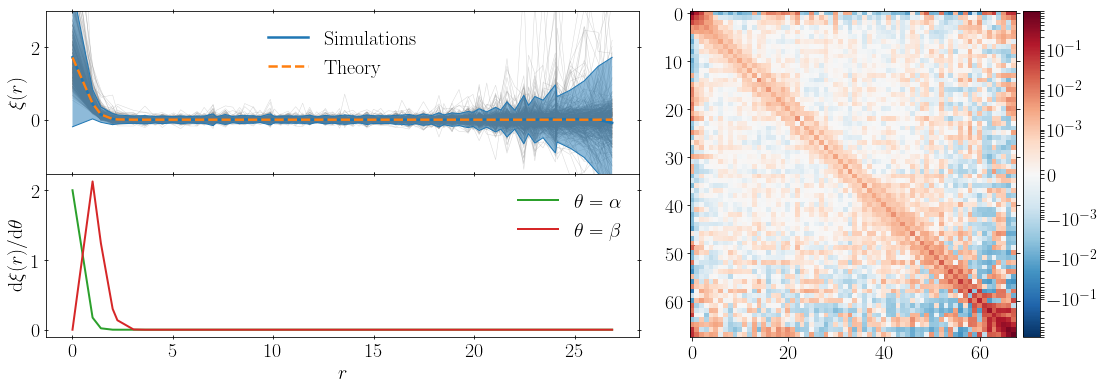

In [5]:
fig = plt.figure(figsize=(20,6))
gs = fig.add_gridspec(2, 2, hspace=0., wspace=-0.12)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_ylabel('$\\xi(r)$')
ax0.set_ylim([-1.5,3])
ax0.tick_params(axis="x",direction="inout",bottom=True,top=True)
ax0.tick_params(axis="y",direction="inout",left=True,right=True)
plt.setp(ax0.get_xticklabels(), visible=False)

for i in range(nsims):
    ax0.plot(average_r,lognormfields[i]['corrfn'],color="grey",lw=0.5,alpha=0.3,zorder=0.5)

# Plot the mean correlation function:
ax0.plot(average_r,mean2pt,lw=2.5,label="Simulations")

# Plot the diagonal of the covariance matrix.  Wild fluctuations are from varying numbers of pairs per bin
ax0.fill_between(average_r,mean2pt-2*np.sqrt(np.diag(cov)),mean2pt+2*np.sqrt(np.diag(cov)),alpha=0.5)
ax0.plot(average_r,mean2pt-2*np.sqrt(np.diag(cov)),c='C0',lw=1.)
ax0.plot(average_r,mean2pt+2*np.sqrt(np.diag(cov)),c='C0',lw=1.)

# Plot the mean correlation function and the theory with the correct alpha, beta :
ax0.plot(average_r,xiLN,ls='--',lw=2.5,label="Theory")
ax0.legend(loc='best',frameon=False)

ax1 = fig.add_subplot(gs[1,0], sharex=ax0)
ax1.set_xlabel('$r$')
ax1.set_ylabel('$\\mathrm{d}\\xi(r)/\\mathrm{d}\\theta$')
ax1.tick_params(axis="x",direction="inout",bottom=True,top=True)
ax1.tick_params(axis="y",direction="inout",left=True,right=True)

# Plot the gradients
ax1.plot(average_r,dxiLN_dalpha,label="$\\theta=\\alpha$",color='C2')
ax1.plot(average_r,dxiLN_dbeta,label="$\\theta=\\beta$",color='C3')
ax1.legend(loc='best',frameon=False)

# Plot the covariance matrix
ax2 = fig.add_subplot(gs[:,-1])
ax2.tick_params(axis="x",direction="out",bottom=True,top=True)
ax2.tick_params(axis="y",direction="out",left=True,right=True)

im2 = ax2.pcolormesh(np.arange(cov.shape[0]), np.arange(cov.shape[1]), cov,
                       norm=mcolors.SymLogNorm(linthresh=1e-4, linscale=0.1,
                                              vmin=-cov.max(), vmax=cov.max(), base=10),
                       cmap='RdBu_r', shading='auto')

ax2.invert_yaxis()
ax2.set_aspect('equal')
d2 = make_axes_locatable(ax2)
cax2 = d2.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im2, cax=cax2)
tick_labels=np.array([item.get_text() for item in cbar.ax.get_yticklabels()])
tick_labels=np.where(tick_labels=='$\\mathdefault{10^{-4}}$','',tick_labels)
tick_labels=np.where(tick_labels=='$\\mathdefault{-10^{-4}}$','',tick_labels)
cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels(tick_labels)

plt.savefig(fileout+'_corrfn.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_corrfn.png',dpi=100,bbox_inches="tight")

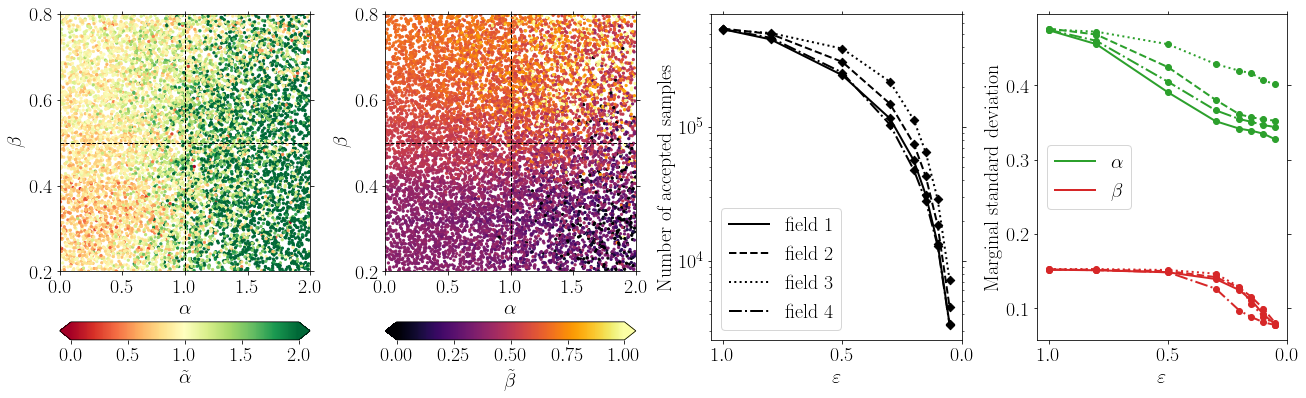

In [6]:
N=10000
fig=plt.figure(figsize=(22,6))

ax0=fig.add_subplot(1,4,1)
ax0.set_xlabel("$\\alpha$")
ax0.set_ylabel("$\\beta$")
ax0.tick_params(axis="x",direction="out",bottom=True,top=True)
ax0.tick_params(axis="y",direction="out",left=True,right=True)
ax0.axvline(alpha,lw=1,ls="--",color="k",zorder=5)
ax0.axhline(beta,lw=1,ls="--",color="k",zorder=5)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
im0 = ax0.scatter(alpha_pool[:N], beta_pool[:N], c=comp_pool[:N].T[0], s=5., vmin=0., vmax=2., cmap="RdYlGn")
ax0_divider = make_axes_locatable(ax0)
cax0 = ax0_divider.append_axes("bottom", size="7%", pad=0.7)
cb0 = fig.colorbar(im0, cax=cax0, orientation="horizontal", extend="both")
cb0.ax.set_xlabel("$\\tilde{\\alpha}$")

ax1=fig.add_subplot(1,4,2)
ax1.set_xlabel("$\\alpha$")
ax1.set_ylabel("$\\beta$")
ax1.tick_params(axis="x",direction="out",bottom=True,top=True)
ax1.tick_params(axis="y",direction="out",left=True,right=True)
ax1.axvline(alpha,lw=1,ls="--",color="k",zorder=5)
ax1.axhline(beta,lw=1,ls="--",color="k",zorder=5)
ax1.set_xlim([alphamin,alphamax])
ax1.set_ylim([betamin,betamax])
im1 = ax1.scatter(alpha_pool[:N], beta_pool[:N], c=comp_pool[:N].T[1], s=5., vmin=0., vmax=1., cmap="inferno")
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("bottom", size="7%", pad=0.7)
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", extend="both")
cb1.ax.set_xlabel("$\\tilde{\\beta}$")

ax2=fig.add_subplot(1,4,3)
ax2.set_xlim([1.05,0])
ax2.tick_params(which="both",axis="x",direction="out",bottom=True,top=True)
ax2.tick_params(which="both",axis="y",direction="out",left=True,right=True)
ax2.set_xlabel("$\\varepsilon$")
ax2.set_ylabel("Number of accepted samples")
for f in range(nfields):
    ax2.scatter(epsilons,sample_size[f],marker='D',color='k')
ax2.semilogy(epsilons,sample_size[0],ls='-',color='k',label="field 1")
ax2.semilogy(epsilons,sample_size[1],ls='--',color='k',label="field 2")
ax2.semilogy(epsilons,sample_size[2],ls=':',color='k',label="field 3")
ax2.semilogy(epsilons,sample_size[3],ls='-.',color='k',label="field 4")
ax2.legend(loc="lower left")

ax3=fig.add_subplot(1,4,4)
ax3.set_xlim([1.05,0])
ax3.tick_params(axis="x",direction="out",bottom=True,top=True)
ax3.tick_params(axis="y",direction="out",left=True,right=True)
ax3.set_xlabel("$\\varepsilon$")
ax3.set_ylabel("Marginal standard deviation")
for f in range(nfields):
    ax3.scatter(epsilons,alpha_marginal_stds[f],marker='o',color='C2')
    ax3.scatter(epsilons,beta_marginal_stds[f],marker='o',color='C3')
ax3.plot(epsilons,alpha_marginal_stds[0],ls='-',color='C2',label='$\\alpha$')
ax3.plot(epsilons,beta_marginal_stds[0],ls='-',color='C3',label='$\\beta$')
ax3.plot(epsilons,alpha_marginal_stds[1],ls='--',color='C2')
ax3.plot(epsilons,beta_marginal_stds[1],ls='--',color='C3')
ax3.plot(epsilons,alpha_marginal_stds[2],ls=':',color='C2')
ax3.plot(epsilons,beta_marginal_stds[2],ls=':',color='C3',)
ax3.plot(epsilons,alpha_marginal_stds[3],ls='-.',color='C2')
ax3.plot(epsilons,beta_marginal_stds[3],ls='-.',color='C3')
ax3.legend(loc="center left")

plt.subplots_adjust(wspace=0.30)
plt.savefig(fileout+'_simulations.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_simulations.png',dpi=100,bbox_inches="tight")

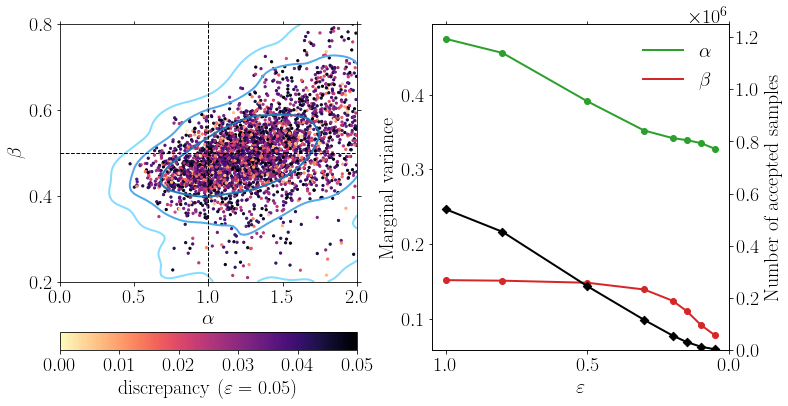

In [7]:
f=0
epsilon=0.05
N=10000
fig=plt.figure(figsize=(12,6))

ax0=fig.add_subplot(1,2,1)
ax0.set_xlabel("$\\alpha$")
ax0.set_ylabel("$\\beta$")
ax0.tick_params(axis="x",direction="out",bottom=True,top=True)
ax0.tick_params(axis="y",direction="out",left=True,right=True)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
ax0.axvline(alpha,lw=1,ls="--",color="k",zorder=5)
ax0.axhline(beta,lw=1,ls="--",color="k",zorder=5)
im0 = ax0.scatter(alpha_samples[f,epsilon][:N], beta_samples[f,epsilon][:N], c=disc_samples[f,epsilon][:N], s=5., vmin=0, vmax=0.05, cmap='magma_r')
ax0.contour(alphas_sbi, betas_sbi, sbi_lnL0[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax0_divider = make_axes_locatable(ax0)
cax0 = ax0_divider.append_axes("bottom", size="7%", pad=0.7)
cb0 = fig.colorbar(im0, cax=cax0, orientation="horizontal")
cb0.set_ticks([0,0.01,0.02,0.03,0.04,0.05])
cb0.ax.set_xlabel("discrepancy ($\\varepsilon=0.05$)")

ax1=fig.add_subplot(1,2,2)
ax1.set_xlim([1.05,0])
ax1.tick_params(axis="x",direction="out",bottom=True,top=True)
ax1.set_xlabel("$\\varepsilon$")
ax1.set_ylabel("Marginal variance")
ax1.scatter(epsilons,alpha_marginal_stds[f],marker='o',color='C2')
ax1.plot(epsilons,alpha_marginal_stds[f],color='C2',label='$\\alpha$')
ax1.scatter(epsilons,beta_marginal_stds[f],marker='o',color='C3')
ax1.plot(epsilons,beta_marginal_stds[f],color='C3',label="$\\beta$")

ax2=ax1.twinx()
ax2.set_ylim(0,1.25e6)
ax2.set_ylabel("Number of accepted samples")
ax2.scatter(epsilons,sample_size[f],marker='D',color='k')
ax2.plot(epsilons,sample_size[f],color='k')

ax1.legend(loc="best",frameon=False)

plt.subplots_adjust(wspace=0.25)
plt.savefig(fileout+'_sbi.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_sbi.png',dpi=100,bbox_inches="tight")

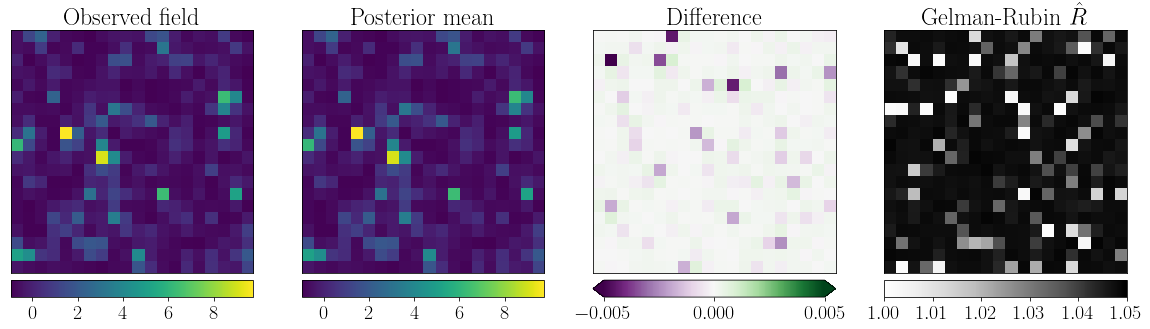

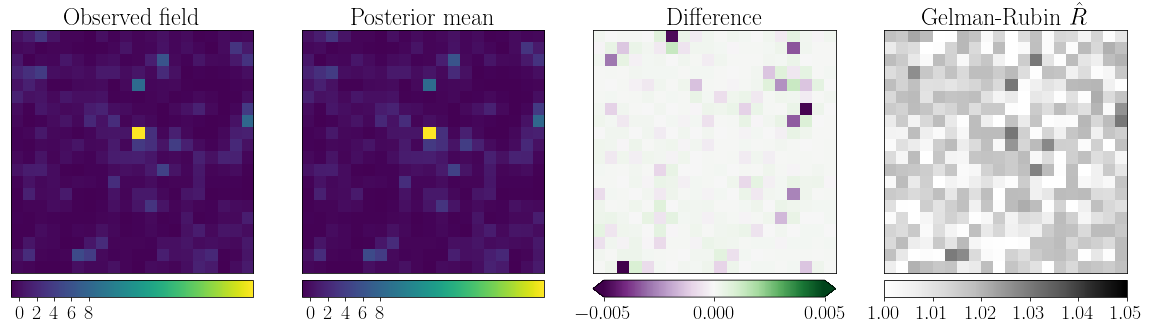

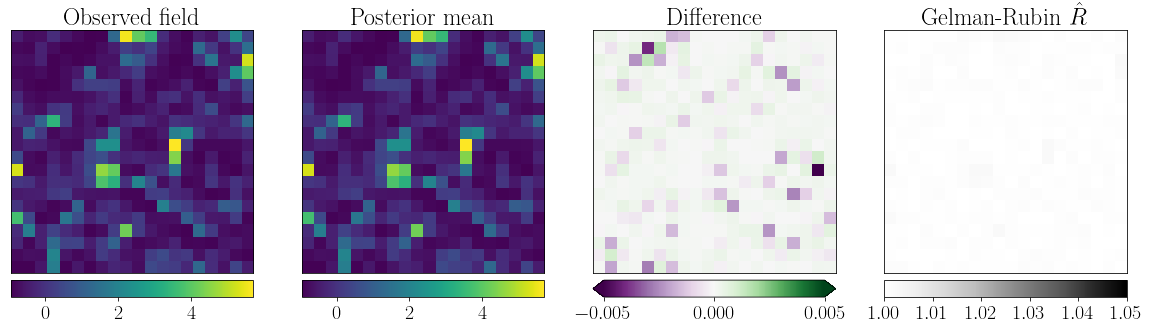

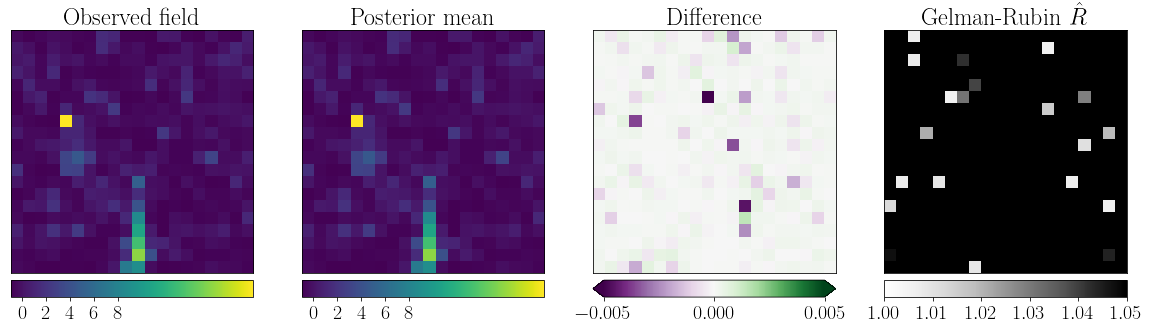

In [8]:
for f in range(nfields):
    vmin=np.min((field_data[f].min(),field_posterior_mean[f].min()))
    vmax=np.max((field_data[f].max(),field_posterior_mean[f].max()))

    fig=plt.figure(figsize=(20,6))
    ax0=fig.add_subplot(1,4,1)
    ax0.set_xticks([])
    ax0.set_yticks([])
    im0 = ax0.imshow(field_data[f], cmap='viridis', vmin=vmin, vmax=vmax)
    ax0.set_title("Observed field")
    ax0_divider = make_axes_locatable(ax0)
    cax0 = ax0_divider.append_axes("bottom", size="7%", pad=0.1)
    cb0 = fig.colorbar(im0, cax=cax0, orientation="horizontal")
    cb0.set_ticks([0,2,4,6,8])

    ax1=fig.add_subplot(1,4,2)
    ax1.set_xticks([])
    ax1.set_yticks([])
    im1 = ax1.imshow(field_posterior_mean[f], cmap='viridis',  vmin=vmin, vmax=vmax)
    ax1.set_title("Posterior mean")
    ax1_divider = make_axes_locatable(ax1)
    cax1 = ax1_divider.append_axes("bottom", size="7%", pad=0.1)
    cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal")
    cb1.set_ticks([0,2,4,6,8])

    ax2=fig.add_subplot(1,4,3)
    ax2.set_xticks([])
    ax2.set_yticks([])
    im2 = ax2.imshow(field_difference[f], cmap='PRGn', vmin=-0.005, vmax=0.005)
    ax2.set_title("Difference")
    ax2_divider = make_axes_locatable(ax2)
    cax2 = ax2_divider.append_axes("bottom", size="7%", pad=0.1)
    cb2 = fig.colorbar(im2, cax=cax2, orientation="horizontal", extend='both')
    cb2.set_ticks([-0.005,0.,0.005])

    ax3=fig.add_subplot(1,4,4)
    ax3.set_xticks([])
    ax3.set_yticks([])
    im3 = ax3.imshow(field_rhat[f], cmap='Greys', vmin=1., vmax=1.05)
    ax3.set_title("Gelman-Rubin $\\hat{R}$")
    ax3_divider = make_axes_locatable(ax3)
    cax3 = ax3_divider.append_axes("bottom", size="7%", pad=0.1)
    cb3 = fig.colorbar(im3, cax=cax3, orientation="horizontal")
    cb3.set_ticks([1,1.01,1.02,1.03,1.04,1.05])

    plt.savefig(fileout+'_field_posterior_'+str(f)+'.pdf',dpi=300,bbox_inches="tight",transparent=True)
    plt.savefig(fileout+'_field_posterior_'+str(f)+'.png',dpi=100,bbox_inches="tight")

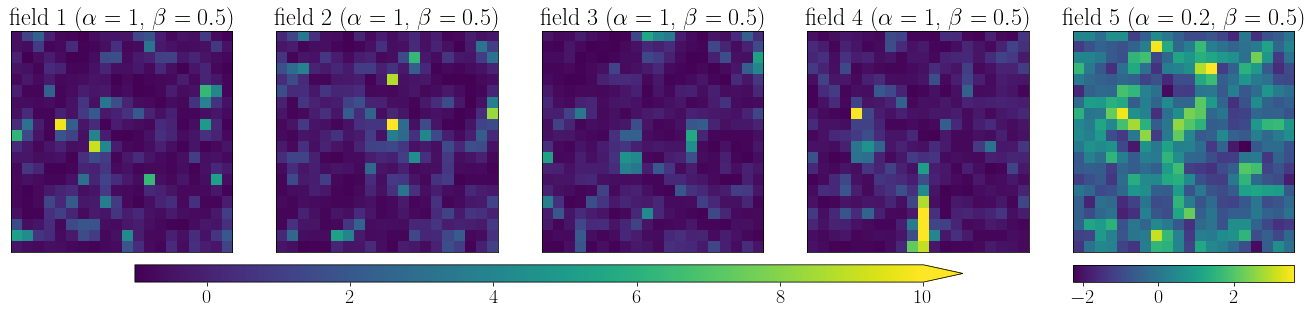

In [9]:
fig=plt.figure(figsize=(23,12))
inset_size=0.07

vmin=-1.
vmax=10.

axA=fig.add_subplot(1,5,1)
axA.set_title("field 1 ($\\alpha=1$, $\\beta=0.5$)")
axA.set_xticks([])
axA.set_yticks([])
imA = axA.imshow(field_data[0], cmap='viridis', vmin=vmin, vmax=vmax)
axB=fig.add_subplot(1,5,2)
axB.set_title("field 2 ($\\alpha=1$, $\\beta=0.5$)")
axB.set_xticks([])
axB.set_yticks([])
imB = axB.imshow(field_data[1], cmap='viridis', vmin=vmin, vmax=vmax)
axC=fig.add_subplot(1,5,3)
axC.set_title("field 3 ($\\alpha=1$, $\\beta=0.5$)")
axC.set_xticks([])
axC.set_yticks([])
imC = axC.imshow(field_data[2], cmap='viridis', vmin=vmin, vmax=vmax)
axD=fig.add_subplot(1,5,4)
axD.set_title("field 4 ($\\alpha=1$, $\\beta=0.5$)")
axD.set_xticks([])
axD.set_yticks([])
imD = axD.imshow(field_data[3], cmap='viridis', vmin=vmin, vmax=vmax)
axE=fig.add_subplot(1,5,5)
axE.set_title("field 5 ($\\alpha=0.2$, $\\beta=0.5$)")
axE.set_xticks([])
axE.set_yticks([])
imE = axE.imshow(field_data[4], cmap='viridis', vmin=field_data[4].min(), vmax=field_data[4].max())

cbar_ax0 = fig.add_axes([0.2, 0.34, 0.5, 0.02])
cb0 = fig.colorbar(imD, cax=cbar_ax0, orientation="horizontal", extend="max")
cbar_ax1 = fig.add_axes([0.7662, 0.34, 0.1337, 0.02])
cb1 = fig.colorbar(imE, cax=cbar_ax1, orientation="horizontal")

plt.savefig('figures/fields.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig('figures/fields.png',dpi=100,bbox_inches="tight")

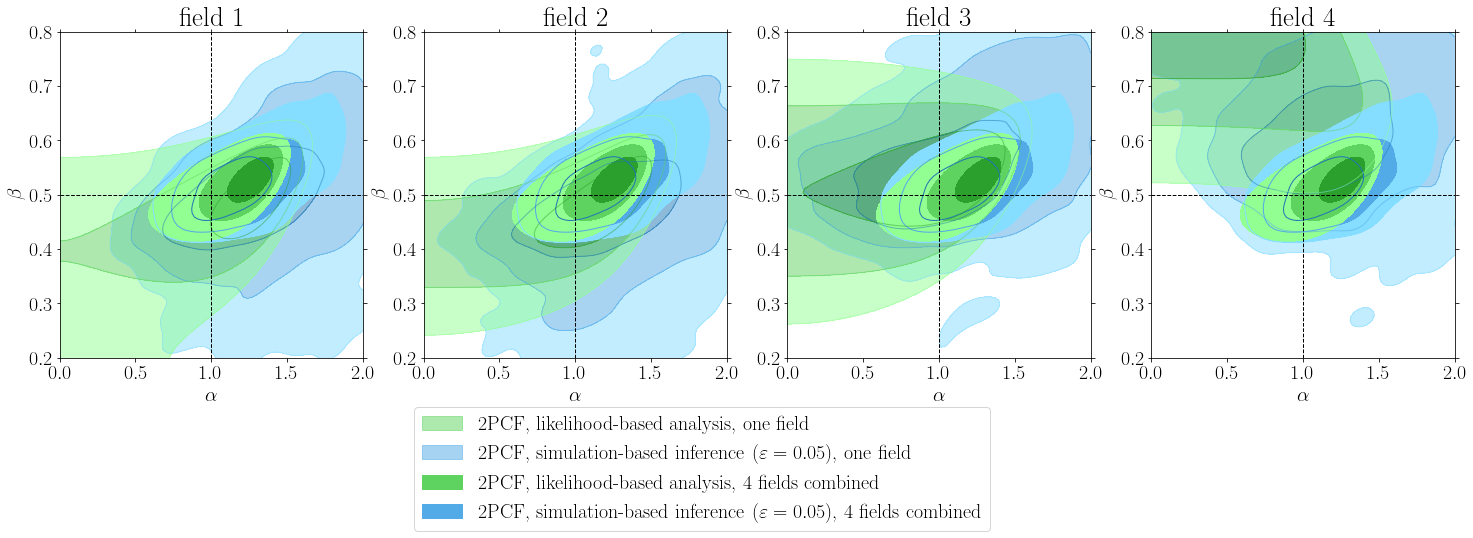

In [10]:
epsilon = 0.05
fig=plt.figure(figsize=(25,6))

ax0=fig.add_subplot(1,4,1)
ax0.set_xlabel("$\\alpha$")
ax0.set_ylabel("$\\beta$")
ax0.tick_params(axis="x",direction="out",bottom=True,top=True)
ax0.tick_params(axis="y",direction="out",left=True,right=True)
ax0.set_title("field 1", fontsize=27)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
ax0.axvline(alpha,lw=1,ls="--",color="k")
ax0.axhline(beta,lw=1,ls="--",color="k")
# Single field background
ax0.contourf(alphas_sbi, betas_sbi, sbi_lnL0[epsilon], confLevels_grid, colors=np.flip(colors[0]), alpha=0.5)
ax0.contourf(alphas_sum, betas_sum, sum_lnL0, confLevels_grid, colors=np.flip(colors[2]), alpha=0.5)
# SBI
ax0.contourf(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax0.contour(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
# Summaries
ax0.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))
# Single field foreground
ax0.contour(alphas_sbi, betas_sbi, sbi_lnL0[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1., alpha=0.5)
ax0.contour(alphas_sum, betas_sum, sum_lnL0, confLevels_grid, colors=np.flip(colors[2]), linewidths=1., alpha=0.5)

ax1=fig.add_subplot(1,4,2)
ax1.set_xlabel("$\\alpha$")
ax1.set_ylabel("$\\beta$")
ax1.tick_params(axis="x",direction="out",bottom=True,top=True)
ax1.tick_params(axis="y",direction="out",left=True,right=True)
ax1.set_title("field 2", fontsize=27)
ax1.set_xlim([alphamin,alphamax])
ax1.set_ylim([betamin,betamax])
ax1.axvline(alpha,lw=1,ls="--",color="k")
ax1.axhline(beta,lw=1,ls="--",color="k")
# Single field background
ax1.contourf(alphas_sbi, betas_sbi, sbi_lnL1[epsilon], confLevels_grid, colors=np.flip(colors[0]), alpha=0.5)
ax1.contourf(alphas_sum, betas_sum, sum_lnL1, confLevels_grid, colors=np.flip(colors[2]), alpha=0.5)
# SBI
ax1.contourf(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax1.contour(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
# Summaries
ax1.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))
# Single field foreground
ax1.contour(alphas_sbi, betas_sbi, sbi_lnL1[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1., alpha=0.5)
ax1.contour(alphas_sum, betas_sum, sum_lnL1, confLevels_grid, colors=np.flip(colors[2]), linewidths=1., alpha=0.5)

ax2=fig.add_subplot(1,4,3)
ax2.set_xlabel("$\\alpha$")
ax2.set_ylabel("$\\beta$")
ax2.tick_params(axis="x",direction="out",bottom=True,top=True)
ax2.tick_params(axis="y",direction="out",left=True,right=True)
ax2.set_title("field 3", fontsize=27)
ax2.set_xlim([alphamin,alphamax])
ax2.set_ylim([betamin,betamax])
ax2.axvline(alpha,lw=1,ls="--",color="k")
ax2.axhline(beta,lw=1,ls="--",color="k")
# Single field background
ax2.contourf(alphas_sbi, betas_sbi, sbi_lnL2[epsilon], confLevels_grid, colors=np.flip(colors[0]), alpha=0.5)
ax2.contourf(alphas_sum, betas_sum, sum_lnL2, confLevels_grid, colors=np.flip(colors[2]), alpha=0.5)
# SBI
ax2.contourf(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax2.contour(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
# Summaries
ax2.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))
# Single field foreground
ax2.contour(alphas_sbi, betas_sbi, sbi_lnL2[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1., alpha=0.5)
ax2.contour(alphas_sum, betas_sum, sum_lnL2, confLevels_grid, colors=np.flip(colors[2]), linewidths=1., alpha=0.5)

ax3=fig.add_subplot(1,4,4)
ax3.set_xlabel("$\\alpha$")
ax3.set_ylabel("$\\beta$")
ax3.tick_params(axis="x",direction="out",bottom=True,top=True)
ax3.tick_params(axis="y",direction="out",left=True,right=True)
ax3.set_title("field 4", fontsize=27)
ax3.set_xlim([alphamin,alphamax])
ax3.set_ylim([betamin,betamax])
ax3.axvline(alpha,lw=1,ls="--",color="k")
ax3.axhline(beta,lw=1,ls="--",color="k")
# Single field background
ax3.contourf(alphas_sbi, betas_sbi, sbi_lnL3[epsilon], confLevels_grid, colors=np.flip(colors[0]), alpha=0.5)
ax3.contourf(alphas_sum, betas_sum, sum_lnL3, confLevels_grid, colors=np.flip(colors[2]), alpha=0.5)
# SBI
ax3.contourf(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax3.contour(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
# Summaries
ax3.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))
# Single field foreground
ax3.contour(alphas_sbi, betas_sbi, sbi_lnL3[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1., alpha=0.5)
ax3.contour(alphas_sum, betas_sum, sum_lnL3, confLevels_grid, colors=np.flip(colors[2]), linewidths=1., alpha=0.5)

patch1a = mpatches.Patch(color=colors[2][1], alpha=0.5, label='2PCF, likelihood-based analysis, one field')
patch2a = mpatches.Patch(color=colors[0][1], alpha=0.5, label='2PCF, simulation-based inference ($\\varepsilon='+str(epsilon)+'$), one field')
patch1b = mpatches.Patch(color=colors[2][1], label='2PCF, likelihood-based analysis, 4 fields combined')
patch2b = mpatches.Patch(color=colors[0][1], label='2PCF, simulation-based inference ($\\varepsilon='+str(epsilon)+'$), 4 fields combined')
plt.legend(handles=[patch1a,patch2a,patch1b,patch2b],bbox_to_anchor=(-0.5, -0.12))

plt.savefig(fileout+'_posterior_sbi_'+str(nfields)+'fields_comb.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_posterior_sbi_'+str(nfields)+'fields_comb.png',dpi=100,bbox_inches="tight")

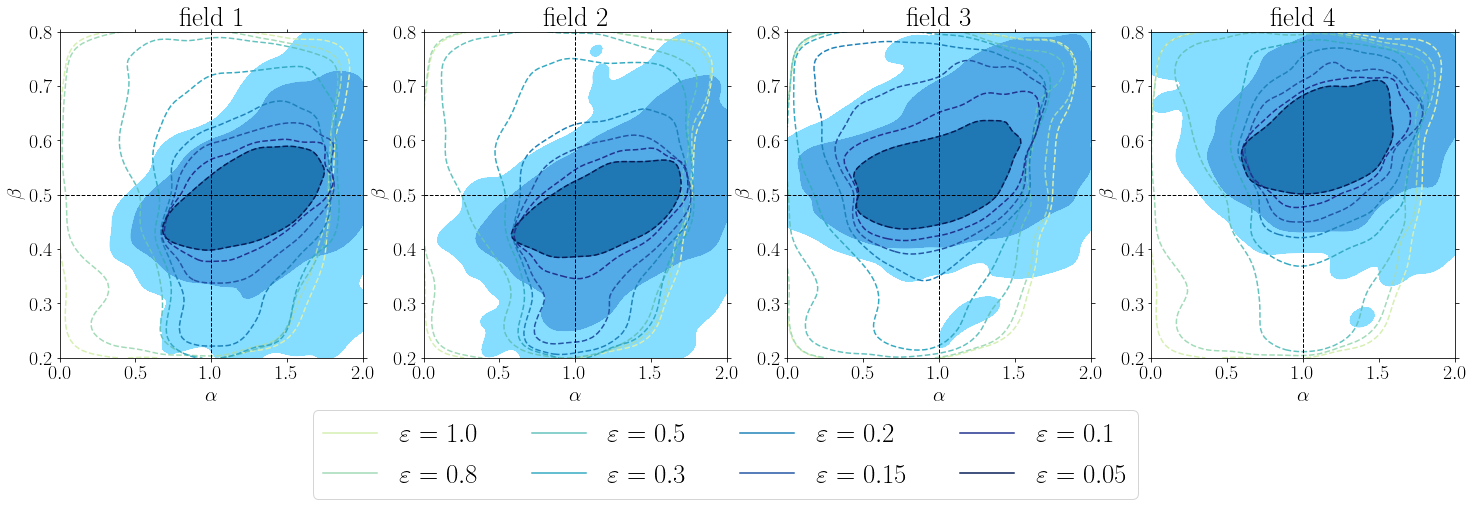

In [11]:
epsilon = 0.05
fig=plt.figure(figsize=(25,6))

epsilon_colors = [mcolors.rgb2hex(plt.cm.YlGnBu(i)) for i in np.linspace(0.2,1,len(epsilons))]

ax0=fig.add_subplot(1,4,1)
ax0.set_xlabel("$\\alpha$")
ax0.set_ylabel("$\\beta$")
ax0.tick_params(axis="x",direction="out",bottom=True,top=True)
ax0.tick_params(axis="y",direction="out",left=True,right=True)
ax0.set_title("field 1", fontsize=27)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
ax0.axvline(alpha,lw=1,ls="--",color="k")
ax0.axhline(beta,lw=1,ls="--",color="k")
ax0.contourf(alphas_sbi, betas_sbi, sbi_lnL0[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax0.contour(alphas_sbi, betas_sbi, sbi_lnL0[epsilon], confLevels_grid, colors=np.flip(colors[0]),linewidths=1)
for i, epsilon in enumerate(epsilons):
    ax0.contour(alphas_sbi, betas_sbi, sbi_lnL0[epsilon], [confLevels_grid[-2],0],
               colors=epsilon_colors[i], linestyles='--', linewidths=1.5)
    ax0.plot([0], [0], color=epsilon_colors[i], linewidth=1.5, label='$\\varepsilon='+str(epsilon)+'$')

ax1=fig.add_subplot(1,4,2)
ax1.set_xlabel("$\\alpha$")
ax1.set_ylabel("$\\beta$")
ax1.tick_params(axis="x",direction="out",bottom=True,top=True)
ax1.tick_params(axis="y",direction="out",left=True,right=True)
ax1.set_title("field 2", fontsize=27)
ax1.set_xlim([alphamin,alphamax])
ax1.set_ylim([betamin,betamax])
ax1.axvline(alpha,lw=1,ls="--",color="k")
ax1.axhline(beta,lw=1,ls="--",color="k")
ax1.contourf(alphas_sbi, betas_sbi, sbi_lnL1[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax1.contour(alphas_sbi, betas_sbi, sbi_lnL1[epsilon], confLevels_grid, colors=np.flip(colors[0]),linewidths=1)
for i, epsilon in enumerate(epsilons):
    ax1.contour(alphas_sbi, betas_sbi, sbi_lnL1[epsilon], [confLevels_grid[-2],0],
               colors=epsilon_colors[i], linestyles='--', linewidths=1.5)
    ax1.plot([0], [0], color=epsilon_colors[i], linewidth=1.5, label='$\\varepsilon='+str(epsilon)+'$')

ax2=fig.add_subplot(1,4,3)
ax2.set_xlabel("$\\alpha$")
ax2.set_ylabel("$\\beta$")
ax2.tick_params(axis="x",direction="out",bottom=True,top=True)
ax2.tick_params(axis="y",direction="out",left=True,right=True)
ax2.set_title("field 3", fontsize=27)
ax2.set_xlim([alphamin,alphamax])
ax2.set_ylim([betamin,betamax])
ax2.axvline(alpha,lw=1,ls="--",color="k")
ax2.axhline(beta,lw=1,ls="--",color="k")
ax2.contourf(alphas_sbi, betas_sbi, sbi_lnL2[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax2.contour(alphas_sbi, betas_sbi, sbi_lnL2[epsilon], confLevels_grid, colors=np.flip(colors[0]),linewidths=1)
for i, epsilon in enumerate(epsilons):
    ax2.contour(alphas_sbi, betas_sbi, sbi_lnL2[epsilon], [confLevels_grid[-2],0],
               colors=epsilon_colors[i], linestyles='--', linewidths=1.5)
    ax2.plot([0], [0], color=epsilon_colors[i], linewidth=1.5, label='$\\varepsilon='+str(epsilon)+'$')

ax3=fig.add_subplot(1,4,4)
ax3.set_xlabel("$\\alpha$")
ax3.set_ylabel("$\\beta$")
ax3.tick_params(axis="x",direction="out",bottom=True,top=True)
ax3.tick_params(axis="y",direction="out",left=True,right=True)
ax3.set_title("field 4", fontsize=27)
ax3.set_xlim([alphamin,alphamax])
ax3.set_ylim([betamin,betamax])
ax3.axvline(alpha,lw=1,ls="--",color="k")
ax3.axhline(beta,lw=1,ls="--",color="k")
ax3.contourf(alphas_sbi, betas_sbi, sbi_lnL3[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax3.contour(alphas_sbi, betas_sbi, sbi_lnL3[epsilon], confLevels_grid, colors=np.flip(colors[0]),linewidths=1)
for i, epsilon in enumerate(epsilons):
    ax3.contour(alphas_sbi, betas_sbi, sbi_lnL3[epsilon], [confLevels_grid[-2],0],
               colors=epsilon_colors[i], linestyles='--', linewidths=1.5)
    ax3.plot([0], [0], color=epsilon_colors[i], linewidth=1.5, label='$\\varepsilon='+str(epsilon)+'$')

plt.legend(ncol=4, bbox_to_anchor=(-0., -0.12), fontsize=27)

plt.savefig(fileout+'_posterior_sbi_epsilons_'+str(nfields)+'fields.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_posterior_sbi_epsilons_'+str(nfields)+'fields.png',dpi=100,bbox_inches="tight")

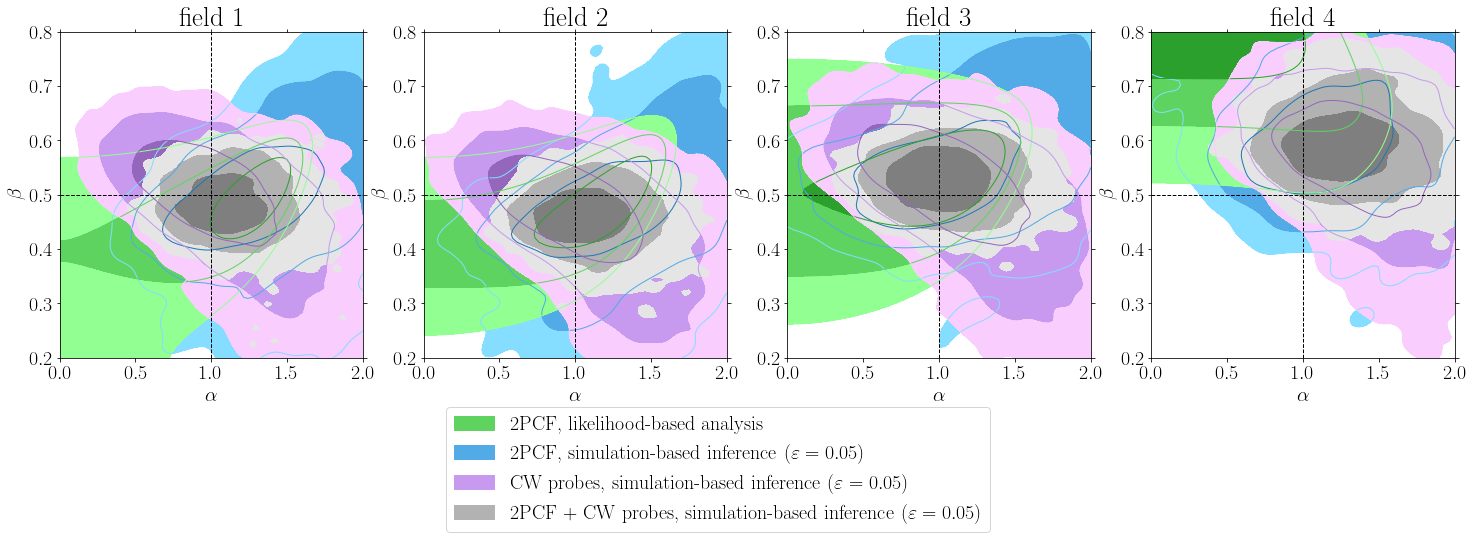

In [12]:
epsilon = 0.05
epsilon_tweb = 0.05
epsilon_comb = 0.05
fig=plt.figure(figsize=(25,6))

ax0=fig.add_subplot(1,4,1)
ax0.set_xlabel("$\\alpha$")
ax0.set_ylabel("$\\beta$")
ax0.tick_params(axis="x",direction="out",bottom=True,top=True)
ax0.tick_params(axis="y",direction="out",left=True,right=True)
ax0.set_title("field 1", fontsize=27)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
ax0.axvline(alpha,lw=1,ls="--",color="k")
ax0.axhline(beta,lw=1,ls="--",color="k")
ax0.contourf(alphas_sbi, betas_sbi, sbi_lnL0[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax0.contourf(alphas_sum, betas_sum, sum_lnL0, confLevels_grid, colors=np.flip(colors[2]))
ax0.contourf(alphas_tweb, betas_tweb, tweb_lnL0[epsilon_tweb], confLevels_grid, colors=np.flip(colors[4]))
ax0.contourf(alphas_comb, betas_comb, comb_lnL0[epsilon_comb], confLevels_grid, colors=np.flip(colors[7]))
ax0.contour(alphas_sbi, betas_sbi, sbi_lnL0[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
ax0.contour(alphas_sum, betas_sum, sum_lnL0, confLevels_grid, colors=np.flip(colors[2]), linewidths=1.)
ax0.contour(alphas_tweb, betas_tweb, tweb_lnL0[epsilon_tweb], confLevels_grid, colors=np.flip(colors[4]), linewidths=1.)

ax1=fig.add_subplot(1,4,2)
ax1.set_xlabel("$\\alpha$")
ax1.set_ylabel("$\\beta$")
ax1.tick_params(axis="x",direction="out",bottom=True,top=True)
ax1.tick_params(axis="y",direction="out",left=True,right=True)
ax1.set_title("field 2", fontsize=27)
ax1.set_xlim([alphamin,alphamax])
ax1.set_ylim([betamin,betamax])
ax1.axvline(alpha,lw=1,ls="--",color="k")
ax1.axhline(beta,lw=1,ls="--",color="k")
ax1.contourf(alphas_sbi, betas_sbi, sbi_lnL1[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax1.contourf(alphas_sum, betas_sum, sum_lnL1, confLevels_grid, colors=np.flip(colors[2]))
ax1.contourf(alphas_tweb, betas_tweb, tweb_lnL1[epsilon_tweb], confLevels_grid, colors=np.flip(colors[4]))
ax1.contourf(alphas_comb, betas_comb, comb_lnL1[epsilon_comb], confLevels_grid, colors=np.flip(colors[7]))
ax1.contour(alphas_sbi, betas_sbi, sbi_lnL1[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
ax1.contour(alphas_sum, betas_sum, sum_lnL1, confLevels_grid, colors=np.flip(colors[2]), linewidths=1.)
ax1.contour(alphas_tweb, betas_tweb, tweb_lnL1[epsilon_tweb], confLevels_grid, colors=np.flip(colors[4]), linewidths=1.)

ax2=fig.add_subplot(1,4,3)
ax2.set_xlabel("$\\alpha$")
ax2.set_ylabel("$\\beta$")
ax2.tick_params(axis="x",direction="out",bottom=True,top=True)
ax2.tick_params(axis="y",direction="out",left=True,right=True)
ax2.set_title("field 3", fontsize=27)
ax2.set_xlim([alphamin,alphamax])
ax2.set_ylim([betamin,betamax])
ax2.axvline(alpha,lw=1,ls="--",color="k")
ax2.axhline(beta,lw=1,ls="--",color="k")
ax2.contourf(alphas_sbi, betas_sbi, sbi_lnL2[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax2.contourf(alphas_sum, betas_sum, sum_lnL2, confLevels_grid, colors=np.flip(colors[2]))
ax2.contourf(alphas_tweb, betas_tweb, tweb_lnL2[epsilon_tweb], confLevels_grid, colors=np.flip(colors[4]))
ax2.contourf(alphas_comb, betas_comb, comb_lnL2[epsilon_comb], confLevels_grid, colors=np.flip(colors[7]))
ax2.contour(alphas_sbi, betas_sbi, sbi_lnL2[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
ax2.contour(alphas_sum, betas_sum, sum_lnL2, confLevels_grid, colors=np.flip(colors[2]), linewidths=1.)
ax2.contour(alphas_tweb, betas_tweb, tweb_lnL2[epsilon_tweb], confLevels_grid, colors=np.flip(colors[4]), linewidths=1.)

ax3=fig.add_subplot(1,4,4)
ax3.set_xlabel("$\\alpha$")
ax3.set_ylabel("$\\beta$")
ax3.tick_params(axis="x",direction="out",bottom=True,top=True)
ax3.tick_params(axis="y",direction="out",left=True,right=True)
ax3.set_title("field 4", fontsize=27)
ax3.set_xlim([alphamin,alphamax])
ax3.set_ylim([betamin,betamax])
ax3.axvline(alpha,lw=1,ls="--",color="k")
ax3.axhline(beta,lw=1,ls="--",color="k")
ax3.contourf(alphas_sbi, betas_sbi, sbi_lnL3[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax3.contourf(alphas_sum, betas_sum, sum_lnL3, confLevels_grid, colors=np.flip(colors[2]))
ax3.contourf(alphas_tweb, betas_tweb, tweb_lnL3[epsilon_tweb], confLevels_grid, colors=np.flip(colors[4]))
ax3.contourf(alphas_comb, betas_comb, comb_lnL3[epsilon_comb], confLevels_grid, colors=np.flip(colors[7]))
ax3.contour(alphas_sbi, betas_sbi, sbi_lnL3[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
ax3.contour(alphas_sum, betas_sum, sum_lnL3, confLevels_grid, colors=np.flip(colors[2]), linewidths=1.)
ax3.contour(alphas_tweb, betas_tweb, tweb_lnL3[epsilon_tweb], confLevels_grid, colors=np.flip(colors[4]), linewidths=1.)

patch1 = mpatches.Patch(color=colors[2][1], label='2PCF, likelihood-based analysis')
patch2 = mpatches.Patch(color=colors[0][1], label='2PCF, simulation-based inference ($\\varepsilon='+str(epsilon)+'$)')
patch3 = mpatches.Patch(color=colors[4][1], label='CW probes, simulation-based inference ($\\varepsilon='+str(epsilon_tweb)+'$)')
patch4 = mpatches.Patch(color=colors[7][1], label='2PCF + CW probes, simulation-based inference ($\\varepsilon='+str(epsilon_comb)+'$)')
plt.legend(handles=[patch1,patch2,patch3,patch4],bbox_to_anchor=(-0.5, -0.12))

plt.savefig(fileout+'_posterior_sbi_tweb_'+str(nfields)+'fields.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_posterior_sbi_tweb_'+str(nfields)+'fields.png',dpi=100,bbox_inches="tight")

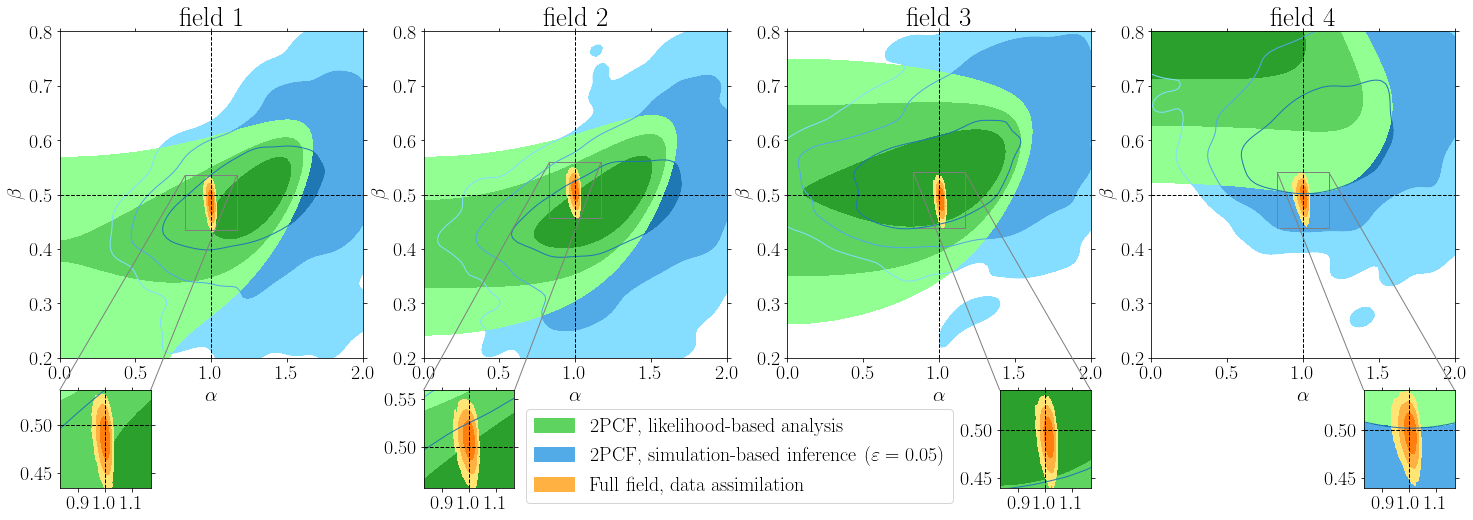

In [13]:
epsilon = 0.05
fig=plt.figure(figsize=(25,6))
inset_size=0.085

ax0=fig.add_subplot(1,4,1)
ax0.set_xlabel("$\\alpha$")
ax0.set_ylabel("$\\beta$")
ax0.tick_params(axis="x",direction="out",bottom=True,top=True)
ax0.tick_params(axis="y",direction="out",left=True,right=True)
ax0.set_title("field 1", fontsize=27)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
ax0.axvline(alpha,lw=1,ls="--",color="k")
ax0.axhline(beta,lw=1,ls="--",color="k")
ax0.contourf(alphas_sbi, betas_sbi, sbi_lnL0[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax0.contourf(alphas_sum, betas_sum, sum_lnL0, confLevels_grid, colors=np.flip(colors[2]))
ax0.contourf(alphas_da, betas_da, da_lnL0, confLevels_grid, colors=np.flip(colors[1]))
ax0.contour(alphas_sbi, betas_sbi, sbi_lnL0[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)

ax0b=fig.add_axes([0,0,1,1], label="ax0b")
ip0=InsetPosition(ax0, [0.,-0.4,0.3,0.3])
ax0b.set_axes_locator(ip0)
ax0b.tick_params(axis="x",direction="out",bottom=True,top=True)
ax0b.tick_params(axis="y",direction="out",left=True,right=True)
alphamean, betamean = 1., 0.485
ax0b.set_xlim([alphamean-inset_size*(alphamax-alphamin),alphamean+inset_size*(alphamax-alphamin)])
ax0b.set_ylim([betamean-inset_size*(betamax-betamin),betamean+inset_size*(betamax-betamin)])
ax0b.axvline(alpha,lw=1,ls="--",color="k")
ax0b.axhline(beta,lw=1,ls="--",color="k")
ax0b.contourf(alphas_sbi, betas_sbi, sbi_lnL0[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax0b.contourf(alphas_sum, betas_sum, sum_lnL0, confLevels_grid, colors=np.flip(colors[2]))
ax0b.contourf(alphas_da, betas_da, da_lnL0, confLevels_grid, colors=np.flip(colors[1]))
ax0b.contour(alphas_sbi, betas_sbi, sbi_lnL0[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
mark_inset(ax0, ax0b, loc1=1, loc2=2, fc="none", ec="0.5", ls=None)

ax1=fig.add_subplot(1,4,2)
ax1.set_xlabel("$\\alpha$")
ax1.set_ylabel("$\\beta$")
ax1.tick_params(axis="x",direction="out",bottom=True,top=True)
ax1.tick_params(axis="y",direction="out",left=True,right=True)
ax1.set_title("field 2", fontsize=27)
ax1.set_xlim([alphamin,alphamax])
ax1.set_ylim([betamin,betamax])
ax1.axvline(alpha,lw=1,ls="--",color="k")
ax1.axhline(beta,lw=1,ls="--",color="k")
ax1.contourf(alphas_sbi, betas_sbi, sbi_lnL1[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax1.contourf(alphas_sum, betas_sum, sum_lnL1, confLevels_grid, colors=np.flip(colors[2]))
ax1.contourf(alphas_da, betas_da, da_lnL1, confLevels_grid, colors=np.flip(colors[1]))
ax1.contour(alphas_sbi, betas_sbi, sbi_lnL1[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)

ax1b = fig.add_axes([0,0,1,1], label="ax1b")
ip1 = InsetPosition(ax1, [0.,-0.4,0.3,0.3])
ax1b.set_axes_locator(ip1)
ax1b.tick_params(axis="x",direction="out",bottom=True,top=True)
ax1b.tick_params(axis="y",direction="out",left=True,right=True)
alphamean, betamean = 1., 0.508
ax1b.set_xlim([alphamean-inset_size*(alphamax-alphamin),alphamean+inset_size*(alphamax-alphamin)])
ax1b.set_ylim([betamean-inset_size*(betamax-betamin),betamean+inset_size*(betamax-betamin)])
ax1b.axvline(alpha,lw=1,ls="--",color="k")
ax1b.axhline(beta,lw=1,ls="--",color="k")
ax1b.contourf(alphas_sbi, betas_sbi, sbi_lnL1[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax1b.contourf(alphas_sum, betas_sum, sum_lnL1, confLevels_grid, colors=np.flip(colors[2]))
ax1b.contourf(alphas_da, betas_da, da_lnL1, confLevels_grid, colors=np.flip(colors[1]))
ax1b.contour(alphas_sbi, betas_sbi, sbi_lnL1[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
mark_inset(ax1, ax1b, loc1=1, loc2=2, fc="none", ec='0.5')

ax2=fig.add_subplot(1,4,3)
ax2.set_xlabel("$\\alpha$")
ax2.set_ylabel("$\\beta$")
ax2.tick_params(axis="x",direction="out",bottom=True,top=True)
ax2.tick_params(axis="y",direction="out",left=True,right=True)
ax2.set_title("field 3", fontsize=27)
ax2.set_xlim([alphamin,alphamax])
ax2.set_ylim([betamin,betamax])
ax2.axvline(alpha,lw=1,ls="--",color="k")
ax2.axhline(beta,lw=1,ls="--",color="k")
ax2.contourf(alphas_sbi, betas_sbi, sbi_lnL2[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax2.contourf(alphas_sum, betas_sum, sum_lnL2, confLevels_grid, colors=np.flip(colors[2]))
ax2.contourf(alphas_da, betas_da, da_lnL2, confLevels_grid, colors=np.flip(colors[1]))
ax2.contour(alphas_sbi, betas_sbi, sbi_lnL2[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)

ax2b=fig.add_axes([0,0,1,1], label="ax2b")
ip2=InsetPosition(ax2, [0.7,-0.4,0.3,0.3])
ax2b.set_axes_locator(ip2)
ax2b.tick_params(axis="x",direction="out",bottom=True,top=True)
ax2b.tick_params(axis="y",direction="out",left=True,right=True)
alphamean, betamean = 1., 0.49
ax2b.set_xlim([alphamean-inset_size*(alphamax-alphamin),alphamean+inset_size*(alphamax-alphamin)])
ax2b.set_ylim([betamean-inset_size*(betamax-betamin),betamean+inset_size*(betamax-betamin)])
ax2b.axvline(alpha,lw=1,ls="--",color="k")
ax2b.axhline(beta,lw=1,ls="--",color="k")
ax2b.contourf(alphas_sbi, betas_sbi, sbi_lnL2[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax2b.contourf(alphas_sum, betas_sum, sum_lnL2, confLevels_grid, colors=np.flip(colors[2]))
ax2b.contourf(alphas_da, betas_da, da_lnL2, confLevels_grid, colors=np.flip(colors[1]))
ax2b.contour(alphas_sbi, betas_sbi, sbi_lnL2[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
mark_inset(ax2, ax2b, loc1=1, loc2=2, fc="none", ec='0.5')

ax3=fig.add_subplot(1,4,4)
ax3.set_xlabel("$\\alpha$")
ax3.set_ylabel("$\\beta$")
ax3.tick_params(axis="x",direction="out",bottom=True,top=True)
ax3.tick_params(axis="y",direction="out",left=True,right=True)
ax3.set_title("field 4", fontsize=27)
ax3.set_xlim([alphamin,alphamax])
ax3.set_ylim([betamin,betamax])
ax3.axvline(alpha,lw=1,ls="--",color="k")
ax3.axhline(beta,lw=1,ls="--",color="k")
ax3.contourf(alphas_sbi, betas_sbi, sbi_lnL3[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax3.contourf(alphas_sum, betas_sum, sum_lnL3, confLevels_grid, colors=np.flip(colors[2]))
ax3.contourf(alphas_da, betas_da, da_lnL3, confLevels_grid, colors=np.flip(colors[1]))
ax3.contour(alphas_sbi, betas_sbi, sbi_lnL3[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)

ax3b=fig.add_axes([0,0,1,1], label="ax3b")
ip3=InsetPosition(ax3, [0.7,-0.4,0.3,0.3])
ax3b.set_axes_locator(ip3)
ax3b.tick_params(axis="x",direction="out",bottom=True,top=True)
ax3b.tick_params(axis="y",direction="out",left=True,right=True)
alphamean, betamean = 1., 0.49
ax3b.set_xlim([alphamean-inset_size*(alphamax-alphamin),alphamean+inset_size*(alphamax-alphamin)])
ax3b.set_ylim([betamean-inset_size*(betamax-betamin),betamean+inset_size*(betamax-betamin)])
ax3b.axvline(alpha,lw=1,ls="--",color="k")
ax3b.axhline(beta,lw=1,ls="--",color="k")
ax3b.contourf(alphas_sbi, betas_sbi, sbi_lnL3[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax3b.contourf(alphas_sum, betas_sum, sum_lnL3, confLevels_grid, colors=np.flip(colors[2]))
ax3b.contourf(alphas_da, betas_da, da_lnL3, confLevels_grid, colors=np.flip(colors[1]))
ax3b.contour(alphas_sbi, betas_sbi, sbi_lnL3[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
mark_inset(ax3, ax3b, loc1=1, loc2=2, fc="none", ec='0.5')

patch1 = mpatches.Patch(color=colors[2][1], label='2PCF, likelihood-based analysis')
patch2 = mpatches.Patch(color=colors[0][1], label='2PCF, simulation-based inference ($\\varepsilon='+str(epsilon)+'$)')
patch3 = mpatches.Patch(color=colors[1][1], label='Full field, data assimilation')
fig.legend(handles=[patch1,patch2,patch3],bbox_to_anchor=(0.627, 0.03))

plt.savefig(fileout+'_posterior_sbi_da_'+str(nfields)+'fields.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_posterior_sbi_da_'+str(nfields)+'fields.png',dpi=100,bbox_inches="tight")

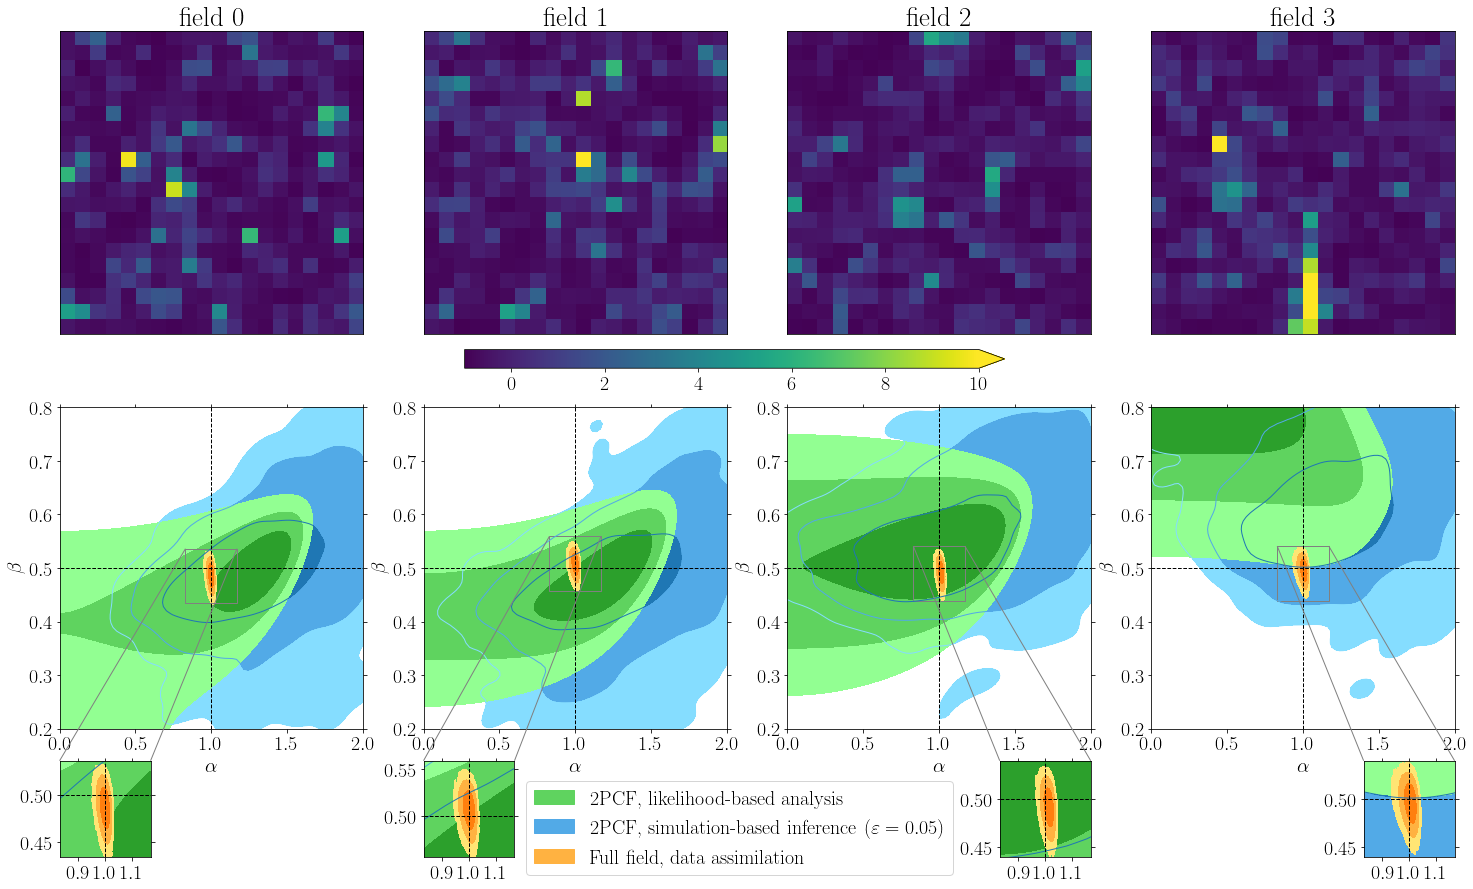

In [14]:
epsilon = 0.05
fig=plt.figure(figsize=(25,13))
inset_size=0.085

vmin=-1.
vmax=10.

axA=fig.add_subplot(2,4,1)
axA.set_title("field 0", fontsize=27)
axA.set_xticks([])
axA.set_yticks([])
imA = axA.imshow(field_data[0], cmap='viridis', vmin=vmin, vmax=vmax)
axB=fig.add_subplot(2,4,2)
axB.set_title("field 1", fontsize=27)
axB.set_xticks([])
axB.set_yticks([])
imB = axB.imshow(field_data[1], cmap='viridis', vmin=vmin, vmax=vmax)
axC=fig.add_subplot(2,4,3)
axC.set_title("field 2", fontsize=27)
axC.set_xticks([])
axC.set_yticks([])
imC = axC.imshow(field_data[2], cmap='viridis', vmin=vmin, vmax=vmax)
axD=fig.add_subplot(2,4,4)
axD.set_title("field 3", fontsize=27)
axD.set_xticks([])
axD.set_yticks([])
imD = axD.imshow(field_data[3], cmap='viridis', vmin=vmin, vmax=vmax)

cbar_ax = fig.add_axes([0.35, 0.51, 0.3, 0.02])
cb = fig.colorbar(imD, cax=cbar_ax, orientation="horizontal", extend="max")

ax0=fig.add_subplot(2,4,5)
ax0.set_xlabel("$\\alpha$")
ax0.set_ylabel("$\\beta$")
ax0.tick_params(axis="x",direction="out",bottom=True,top=True)
ax0.tick_params(axis="y",direction="out",left=True,right=True)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
ax0.axvline(alpha,lw=1,ls="--",color="k")
ax0.axhline(beta,lw=1,ls="--",color="k")
ax0.contourf(alphas_sbi, betas_sbi, sbi_lnL0[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax0.contourf(alphas_sum, betas_sum, sum_lnL0, confLevels_grid, colors=np.flip(colors[2]))
ax0.contourf(alphas_da, betas_da, da_lnL0, confLevels_grid, colors=np.flip(colors[1]))
ax0.contour(alphas_sbi, betas_sbi, sbi_lnL0[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)

ax0b=fig.add_axes([0,0,1,1], label="ax0b")
ip0=InsetPosition(ax0, [0.,-0.4,0.3,0.3])
ax0b.set_axes_locator(ip0)
ax0b.tick_params(axis="x",direction="out",bottom=True,top=True)
ax0b.tick_params(axis="y",direction="out",left=True,right=True)
alphamean, betamean = 1., 0.485
ax0b.set_xlim([alphamean-inset_size*(alphamax-alphamin),alphamean+inset_size*(alphamax-alphamin)])
ax0b.set_ylim([betamean-inset_size*(betamax-betamin),betamean+inset_size*(betamax-betamin)])
ax0b.axvline(alpha,lw=1,ls="--",color="k")
ax0b.axhline(beta,lw=1,ls="--",color="k")
ax0b.contourf(alphas_sbi, betas_sbi, sbi_lnL0[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax0b.contourf(alphas_sum, betas_sum, sum_lnL0, confLevels_grid, colors=np.flip(colors[2]))
ax0b.contourf(alphas_da, betas_da, da_lnL0, confLevels_grid, colors=np.flip(colors[1]))
ax0b.contour(alphas_sbi, betas_sbi, sbi_lnL0[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
mark_inset(ax0, ax0b, loc1=1, loc2=2, fc="none", ec="0.5", ls=None)

ax1=fig.add_subplot(2,4,6)
ax1.set_xlabel("$\\alpha$")
ax1.set_ylabel("$\\beta$")
ax1.tick_params(axis="x",direction="out",bottom=True,top=True)
ax1.tick_params(axis="y",direction="out",left=True,right=True)
ax1.set_xlim([alphamin,alphamax])
ax1.set_ylim([betamin,betamax])
ax1.axvline(alpha,lw=1,ls="--",color="k")
ax1.axhline(beta,lw=1,ls="--",color="k")
ax1.contourf(alphas_sbi, betas_sbi, sbi_lnL1[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax1.contourf(alphas_sum, betas_sum, sum_lnL1, confLevels_grid, colors=np.flip(colors[2]))
ax1.contourf(alphas_da, betas_da, da_lnL1, confLevels_grid, colors=np.flip(colors[1]))
ax1.contour(alphas_sbi, betas_sbi, sbi_lnL1[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)

ax1b = fig.add_axes([0,0,1,1], label="ax1b")
ip1 = InsetPosition(ax1, [0.,-0.4,0.3,0.3])
ax1b.set_axes_locator(ip1)
ax1b.tick_params(axis="x",direction="out",bottom=True,top=True)
ax1b.tick_params(axis="y",direction="out",left=True,right=True)
alphamean, betamean = 1., 0.508
ax1b.set_xlim([alphamean-inset_size*(alphamax-alphamin),alphamean+inset_size*(alphamax-alphamin)])
ax1b.set_ylim([betamean-inset_size*(betamax-betamin),betamean+inset_size*(betamax-betamin)])
ax1b.axvline(alpha,lw=1,ls="--",color="k")
ax1b.axhline(beta,lw=1,ls="--",color="k")
ax1b.contourf(alphas_sbi, betas_sbi, sbi_lnL1[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax1b.contourf(alphas_sum, betas_sum, sum_lnL1, confLevels_grid, colors=np.flip(colors[2]))
ax1b.contourf(alphas_da, betas_da, da_lnL1, confLevels_grid, colors=np.flip(colors[1]))
ax1b.contour(alphas_sbi, betas_sbi, sbi_lnL1[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
mark_inset(ax1, ax1b, loc1=1, loc2=2, fc="none", ec='0.5')

ax2=fig.add_subplot(2,4,7)
ax2.set_xlabel("$\\alpha$")
ax2.set_ylabel("$\\beta$")
ax2.tick_params(axis="x",direction="out",bottom=True,top=True)
ax2.tick_params(axis="y",direction="out",left=True,right=True)
ax2.set_xlim([alphamin,alphamax])
ax2.set_ylim([betamin,betamax])
ax2.axvline(alpha,lw=1,ls="--",color="k")
ax2.axhline(beta,lw=1,ls="--",color="k")
ax2.contourf(alphas_sbi, betas_sbi, sbi_lnL2[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax2.contourf(alphas_sum, betas_sum, sum_lnL2, confLevels_grid, colors=np.flip(colors[2]))
ax2.contourf(alphas_da, betas_da, da_lnL2, confLevels_grid, colors=np.flip(colors[1]))
ax2.contour(alphas_sbi, betas_sbi, sbi_lnL2[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)

ax2b=fig.add_axes([0,0,1,1], label="ax2b")
ip2=InsetPosition(ax2, [0.7,-0.4,0.3,0.3])
ax2b.set_axes_locator(ip2)
ax2b.tick_params(axis="x",direction="out",bottom=True,top=True)
ax2b.tick_params(axis="y",direction="out",left=True,right=True)
alphamean, betamean = 1., 0.49
ax2b.set_xlim([alphamean-inset_size*(alphamax-alphamin),alphamean+inset_size*(alphamax-alphamin)])
ax2b.set_ylim([betamean-inset_size*(betamax-betamin),betamean+inset_size*(betamax-betamin)])
ax2b.axvline(alpha,lw=1,ls="--",color="k")
ax2b.axhline(beta,lw=1,ls="--",color="k")
ax2b.contourf(alphas_sbi, betas_sbi, sbi_lnL2[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax2b.contourf(alphas_sum, betas_sum, sum_lnL2, confLevels_grid, colors=np.flip(colors[2]))
ax2b.contourf(alphas_da, betas_da, da_lnL2, confLevels_grid, colors=np.flip(colors[1]))
ax2b.contour(alphas_sbi, betas_sbi, sbi_lnL2[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
mark_inset(ax2, ax2b, loc1=1, loc2=2, fc="none", ec='0.5')

ax3=fig.add_subplot(2,4,8)
ax3.set_xlabel("$\\alpha$")
ax3.set_ylabel("$\\beta$")
ax3.tick_params(axis="x",direction="out",bottom=True,top=True)
ax3.tick_params(axis="y",direction="out",left=True,right=True)
ax3.set_xlim([alphamin,alphamax])
ax3.set_ylim([betamin,betamax])
ax3.axvline(alpha,lw=1,ls="--",color="k")
ax3.axhline(beta,lw=1,ls="--",color="k")
ax3.contourf(alphas_sbi, betas_sbi, sbi_lnL3[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax3.contourf(alphas_sum, betas_sum, sum_lnL3, confLevels_grid, colors=np.flip(colors[2]))
ax3.contourf(alphas_da, betas_da, da_lnL3, confLevels_grid, colors=np.flip(colors[1]))
ax3.contour(alphas_sbi, betas_sbi, sbi_lnL3[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)

ax3b=fig.add_axes([0,0,1,1], label="ax3b")
ip3=InsetPosition(ax3, [0.7,-0.4,0.3,0.3])
ax3b.set_axes_locator(ip3)
ax3b.tick_params(axis="x",direction="out",bottom=True,top=True)
ax3b.tick_params(axis="y",direction="out",left=True,right=True)
alphamean, betamean = 1., 0.49
ax3b.set_xlim([alphamean-inset_size*(alphamax-alphamin),alphamean+inset_size*(alphamax-alphamin)])
ax3b.set_ylim([betamean-inset_size*(betamax-betamin),betamean+inset_size*(betamax-betamin)])
ax3b.axvline(alpha,lw=1,ls="--",color="k")
ax3b.axhline(beta,lw=1,ls="--",color="k")
ax3b.contourf(alphas_sbi, betas_sbi, sbi_lnL3[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax3b.contourf(alphas_sum, betas_sum, sum_lnL3, confLevels_grid, colors=np.flip(colors[2]))
ax3b.contourf(alphas_da, betas_da, da_lnL3, confLevels_grid, colors=np.flip(colors[1]))
ax3b.contour(alphas_sbi, betas_sbi, sbi_lnL3[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
mark_inset(ax3, ax3b, loc1=1, loc2=2, fc="none", ec='0.5')

patch1 = mpatches.Patch(color=colors[2][1], label='2PCF, likelihood-based analysis')
patch2 = mpatches.Patch(color=colors[0][1], label='2PCF, simulation-based inference ($\\varepsilon='+str(epsilon)+'$)')
patch3 = mpatches.Patch(color=colors[1][1], label='Full field, data assimilation')
fig.legend(handles=[patch1,patch2,patch3],bbox_to_anchor=(0.627, 0.08))

plt.savefig(fileout+'_fields_posterior_sbi_da_'+str(nfields)+'fields.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_fields_posterior_sbi_da_'+str(nfields)+'fields.png',dpi=100,bbox_inches="tight")

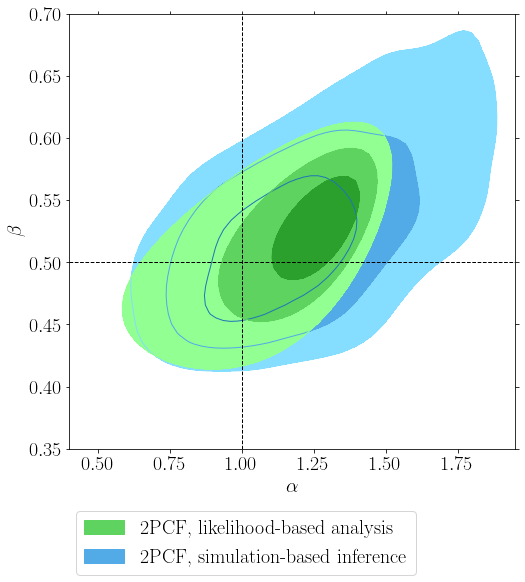

In [15]:
epsilon = 0.05

fig = plt.figure(figsize=(figureWidth,figureWidth))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.tick_params(axis="x",direction="out",bottom=True,top=True)
ax.tick_params(axis="y",direction="out",left=True,right=True)
ax.set_xlim([0.4,1.95])
ax.set_ylim([0.35,0.70])

# Truths
ax.axvline(alpha,lw=1,ls="--",color="k",zorder=5)
ax.axhline(beta,lw=1,ls="--",color="k",zorder=5)

# Single field
# ax.contourf(alphas_sbi, betas_sbi, sbi_lnL0, confLevels_grid, colors=np.flip(colors[0]), alpha=0.5)
# ax.contourf(alphas_sum, betas_sum, sum_lnL0, confLevels_grid, colors=np.flip(colors[2]), alpha=0.5)

# SBI
# ax = plot2d(ax, 1, [sbi_samples.T], [sbi_weights.T], nBins, smoothingKernel,
#             filledPlots, [colorsDict['blues']], nContourLevels, confLevels, truths2d,
#             truthColors, truthLineStyles, plotDensity, myColorMap)
ax.contourf(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]))

# Summaries
ax.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))

# DA
# ax = plot2d(ax, 1, [da_samples.T], [da_weights.T], nBins, smoothingKernel,
#             filledPlots, [colorsDict['oranges']], nContourLevels, confLevels, truths2d,
#             truthColors, truthLineStyles, plotDensity, myColorMap)
# ax.contourf(alphas_da, betas_da, da_lnL, confLevels_grid, colors=np.flip(colors[1]))

# Foregrounds
ax.contour(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
ax.contour(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]), linewidths=1.)

# inset_size = 0.042
# axb=fig.add_axes([0,0,1,1], label="ax0b")
# ip=InsetPosition(ax, [0.12,0.68,0.3,0.3])
# axb.set_axes_locator(ip)
# axb.tick_params(axis="x",direction="out",bottom=True,top=True)
# axb.tick_params(axis="y",direction="out",left=True,right=True)
# alphamean, betamean = 1., 0.495
# axb.set_xlim([alphamean-inset_size*(alphamax-alphamin),alphamean+inset_size*(alphamax-alphamin)])
# axb.set_ylim([betamean-inset_size*(betamax-betamin),betamean+inset_size*(betamax-betamin)])
# axb.axvline(alpha,lw=1,ls="--",color="k")
# axb.axhline(beta,lw=1,ls="--",color="k")
# axb.contourf(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]))
# axb.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))
# axb.contourf(alphas_da, betas_da, da_lnL, confLevels_grid, colors=np.flip(colors[1]))
# axb.contour(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
# axb.contour(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]), linewidths=1.)
# mark_inset(ax, axb, loc1=1, loc2=3, fc="none", ec="0.5", ls=None)

# Legend 1
patch1 = mpatches.Patch(color=colors[2][1], label='2PCF, likelihood-based analysis')
patch2 = mpatches.Patch(color=colors[0][1], label='2PCF, simulation-based inference')
plt.legend(handles=[patch1,patch2],bbox_to_anchor=(0.8, -0.12))

# # Legend 2
# patchlist = []
# patchlist.append([mpatches.Patch(color=colors[2][i]) for i in range(3)])
# patchlist.append([mpatches.Patch(color=colors[0][i]) for i in range(3)])
# patchlist.append([mpatches.Patch(color=colors[1][i]) for i in range(3)])
# categories = ['2PCF, likelihood-based analysis', '2PCF, simulation-based inference ($\\varepsilon='+str(epsilon)+'$)', 'Full field, data assimilation']
# plt.legend(handles=patchlist, labels=categories, handler_map = {list: HandlerTuple(None)}, loc='lower left')

plt.savefig(fileout+'_posterior_sbi_'+str(nfields)+'fields_comb.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_posterior_sbi_'+str(nfields)+'fields_comb.png',dpi=100,bbox_inches="tight")

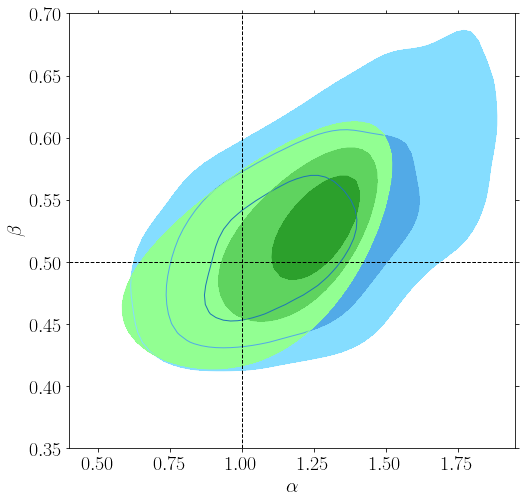

In [16]:
epsilon = 0.05

fig = plt.figure(figsize=(figureWidth,figureWidth))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.tick_params(axis="x",direction="out",bottom=True,top=True)
ax.tick_params(axis="y",direction="out",left=True,right=True)
ax.set_xlim([0.4,1.95])
ax.set_ylim([0.35,0.70])

# Truths
ax.axvline(alpha,lw=1,ls="--",color="k",zorder=5)
ax.axhline(beta,lw=1,ls="--",color="k",zorder=5)

# Single field
# ax.contourf(alphas_sbi, betas_sbi, sbi_lnL0, confLevels_grid, colors=np.flip(colors[0]), alpha=0.5)
# ax.contourf(alphas_sum, betas_sum, sum_lnL0, confLevels_grid, colors=np.flip(colors[2]), alpha=0.5)

# SBI
# ax = plot2d(ax, 1, [sbi_samples.T], [sbi_weights.T], nBins, smoothingKernel,
#             filledPlots, [colorsDict['blues']], nContourLevels, confLevels, truths2d,
#             truthColors, truthLineStyles, plotDensity, myColorMap)
ax.contourf(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]))

# Summaries
ax.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))

# DA
# ax = plot2d(ax, 1, [da_samples.T], [da_weights.T], nBins, smoothingKernel,
#             filledPlots, [colorsDict['oranges']], nContourLevels, confLevels, truths2d,
#             truthColors, truthLineStyles, plotDensity, myColorMap)
# ax.contourf(alphas_da, betas_da, da_lnL, confLevels_grid, colors=np.flip(colors[1]))

# Foregrounds
ax.contour(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
ax.contour(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]), linewidths=1.)

# inset_size = 0.042
# axb=fig.add_axes([0,0,1,1], label="ax0b")
# ip=InsetPosition(ax, [0.12,0.68,0.3,0.3])
# axb.set_axes_locator(ip)
# axb.tick_params(axis="x",direction="out",bottom=True,top=True)
# axb.tick_params(axis="y",direction="out",left=True,right=True)
# alphamean, betamean = 1., 0.495
# axb.set_xlim([alphamean-inset_size*(alphamax-alphamin),alphamean+inset_size*(alphamax-alphamin)])
# axb.set_ylim([betamean-inset_size*(betamax-betamin),betamean+inset_size*(betamax-betamin)])
# axb.axvline(alpha,lw=1,ls="--",color="k")
# axb.axhline(beta,lw=1,ls="--",color="k")
# axb.contourf(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]))
# axb.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))
# axb.contourf(alphas_da, betas_da, da_lnL, confLevels_grid, colors=np.flip(colors[1]))
# axb.contour(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
# axb.contour(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]), linewidths=1.)
# mark_inset(ax, axb, loc1=1, loc2=3, fc="none", ec="0.5", ls=None)

# Legend 1
# patch1 = mpatches.Patch(color=colors[2][1], label='2PCF, likelihood-based analysis')
# patch2 = mpatches.Patch(color=colors[0][1], label='2PCF, simulation-based inference')
# plt.legend(handles=[patch1,patch2],bbox_to_anchor=(0.8, -0.12))

# # Legend 2
# patchlist = []
# patchlist.append([mpatches.Patch(color=colors[2][i]) for i in range(3)])
# patchlist.append([mpatches.Patch(color=colors[0][i]) for i in range(3)])
# patchlist.append([mpatches.Patch(color=colors[1][i]) for i in range(3)])
# categories = ['2PCF, likelihood-based analysis', '2PCF, simulation-based inference ($\\varepsilon='+str(epsilon)+'$)', 'Full field, data assimilation']
# plt.legend(handles=patchlist, labels=categories, handler_map = {list: HandlerTuple(None)}, loc='lower left')

plt.savefig(fileout+'_posterior_sbi_'+str(nfields)+'fields_comb_nolegend.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_posterior_sbi_'+str(nfields)+'fields_comb_nolegend.png',dpi=100,bbox_inches="tight")

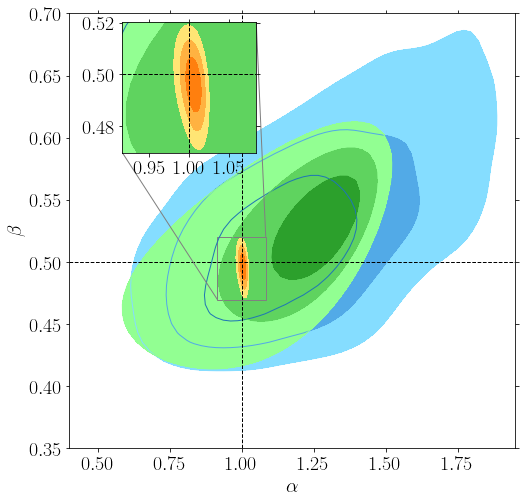

In [17]:
epsilon = 0.05

fig = plt.figure(figsize=(figureWidth,figureWidth))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.tick_params(axis="x",direction="out",bottom=True,top=True)
ax.tick_params(axis="y",direction="out",left=True,right=True)
ax.set_xlim([0.4,1.95])
ax.set_ylim([0.35,0.70])

# Truths
ax.axvline(alpha,lw=1,ls="--",color="k",zorder=5)
ax.axhline(beta,lw=1,ls="--",color="k",zorder=5)

# Single field
# ax.contourf(alphas_sbi, betas_sbi, sbi_lnL0, confLevels_grid, colors=np.flip(colors[0]), alpha=0.5)
# ax.contourf(alphas_sum, betas_sum, sum_lnL0, confLevels_grid, colors=np.flip(colors[2]), alpha=0.5)

# SBI
# ax = plot2d(ax, 1, [sbi_samples.T], [sbi_weights.T], nBins, smoothingKernel,
#             filledPlots, [colorsDict['blues']], nContourLevels, confLevels, truths2d,
#             truthColors, truthLineStyles, plotDensity, myColorMap)
ax.contourf(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]))

# Summaries
ax.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))

# DA
# ax = plot2d(ax, 1, [da_samples.T], [da_weights.T], nBins, smoothingKernel,
#             filledPlots, [colorsDict['oranges']], nContourLevels, confLevels, truths2d,
#             truthColors, truthLineStyles, plotDensity, myColorMap)
ax.contourf(alphas_da, betas_da, da_lnL, confLevels_grid, colors=np.flip(colors[1]))

# Foregrounds
ax.contour(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
ax.contour(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]), linewidths=1.)

inset_size = 0.042
axb=fig.add_axes([0,0,1,1], label="ax0b")
ip=InsetPosition(ax, [0.12,0.68,0.3,0.3])
axb.set_axes_locator(ip)
axb.tick_params(axis="x",direction="out",bottom=True,top=True)
axb.tick_params(axis="y",direction="out",left=True,right=True)
alphamean, betamean = 1., 0.495
axb.set_xlim([alphamean-inset_size*(alphamax-alphamin),alphamean+inset_size*(alphamax-alphamin)])
axb.set_ylim([betamean-inset_size*(betamax-betamin),betamean+inset_size*(betamax-betamin)])
axb.axvline(alpha,lw=1,ls="--",color="k")
axb.axhline(beta,lw=1,ls="--",color="k")
axb.contourf(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]))
axb.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))
axb.contourf(alphas_da, betas_da, da_lnL, confLevels_grid, colors=np.flip(colors[1]))
axb.contour(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
axb.contour(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]), linewidths=1.)
mark_inset(ax, axb, loc1=1, loc2=3, fc="none", ec="0.5", ls=None)

# Legend 1
# patch1 = mpatches.Patch(color=colors[2][1], label='2PCF, likelihood-based analysis')
# patch2 = mpatches.Patch(color=colors[0][1], label='2PCF, simulation-based inference')
# plt.legend(handles=[patch1,patch2],bbox_to_anchor=(0.8, -0.12))

# # Legend 2
# patchlist = []
# patchlist.append([mpatches.Patch(color=colors[2][i]) for i in range(3)])
# patchlist.append([mpatches.Patch(color=colors[0][i]) for i in range(3)])
# patchlist.append([mpatches.Patch(color=colors[1][i]) for i in range(3)])
# categories = ['2PCF, likelihood-based analysis', '2PCF, simulation-based inference ($\\varepsilon='+str(epsilon)+'$)', 'Full field, data assimilation']
# plt.legend(handles=patchlist, labels=categories, handler_map = {list: HandlerTuple(None)}, loc='lower left')

plt.savefig(fileout+'_posterior_sbi_da_'+str(nfields)+'fields_comb_nolegend.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_posterior_sbi_da_'+str(nfields)+'fields_comb_nolegend.png',dpi=100,bbox_inches="tight")

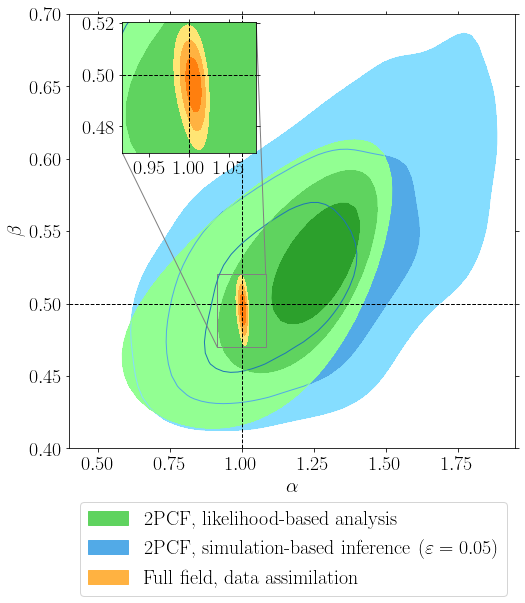

In [18]:
epsilon = 0.05

fig = plt.figure(figsize=(figureWidth,figureWidth))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.tick_params(axis="x",direction="out",bottom=True,top=True)
ax.tick_params(axis="y",direction="out",left=True,right=True)
ax.set_xlim([0.4,1.95])
ax.set_ylim([0.4,0.70])

# Truths
ax.axvline(alpha,lw=1,ls="--",color="k",zorder=5)
ax.axhline(beta,lw=1,ls="--",color="k",zorder=5)

# Single field
# ax.contourf(alphas_sbi, betas_sbi, sbi_lnL0, confLevels_grid, colors=np.flip(colors[0]), alpha=0.5)
# ax.contourf(alphas_sum, betas_sum, sum_lnL0, confLevels_grid, colors=np.flip(colors[2]), alpha=0.5)

# SBI
# ax = plot2d(ax, 1, [sbi_samples.T], [sbi_weights.T], nBins, smoothingKernel,
#             filledPlots, [colorsDict['blues']], nContourLevels, confLevels, truths2d,
#             truthColors, truthLineStyles, plotDensity, myColorMap)
ax.contourf(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]))

# Summaries
ax.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))

# DA
# ax = plot2d(ax, 1, [da_samples.T], [da_weights.T], nBins, smoothingKernel,
#             filledPlots, [colorsDict['oranges']], nContourLevels, confLevels, truths2d,
#             truthColors, truthLineStyles, plotDensity, myColorMap)
ax.contourf(alphas_da, betas_da, da_lnL, confLevels_grid, colors=np.flip(colors[1]))

# Foregrounds
ax.contour(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
ax.contour(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]), linewidths=1.)

inset_size = 0.042
axb=fig.add_axes([0,0,1,1], label="ax0b")
ip=InsetPosition(ax, [0.12,0.68,0.3,0.3])
axb.set_axes_locator(ip)
axb.tick_params(axis="x",direction="out",bottom=True,top=True)
axb.tick_params(axis="y",direction="out",left=True,right=True)
alphamean, betamean = 1., 0.495
axb.set_xlim([alphamean-inset_size*(alphamax-alphamin),alphamean+inset_size*(alphamax-alphamin)])
axb.set_ylim([betamean-inset_size*(betamax-betamin),betamean+inset_size*(betamax-betamin)])
axb.axvline(alpha,lw=1,ls="--",color="k")
axb.axhline(beta,lw=1,ls="--",color="k")
axb.contourf(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]))
axb.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))
axb.contourf(alphas_da, betas_da, da_lnL, confLevels_grid, colors=np.flip(colors[1]))
axb.contour(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
axb.contour(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]), linewidths=1.)
mark_inset(ax, axb, loc1=1, loc2=3, fc="none", ec="0.5", ls=None)

# Legend 1
patch1 = mpatches.Patch(color=colors[2][1], label='2PCF, likelihood-based analysis')
patch2 = mpatches.Patch(color=colors[0][1], label='2PCF, simulation-based inference ($\\varepsilon='+str(epsilon)+'$)')
patch3 = mpatches.Patch(color=colors[1][1], label='Full field, data assimilation')
# plt.legend(handles=[patch1,patch2],loc='lower left')
plt.legend(handles=[patch1,patch2,patch3],bbox_to_anchor=(2.95, -2.6))

# # Legend 2
# patchlist = []
# patchlist.append([mpatches.Patch(color=colors[2][i]) for i in range(3)])
# patchlist.append([mpatches.Patch(color=colors[0][i]) for i in range(3)])
# patchlist.append([mpatches.Patch(color=colors[1][i]) for i in range(3)])
# categories = ['2PCF, likelihood-based analysis', '2PCF, simulation-based inference ($\\varepsilon='+str(epsilon)+'$)', 'Full field, data assimilation']
# plt.legend(handles=patchlist, labels=categories, handler_map = {list: HandlerTuple(None)}, loc='lower left')

plt.savefig(fileout+'_posterior_sbi_da_'+str(nfields)+'fields_comb.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_posterior_sbi_da_'+str(nfields)+'fields_comb.png',dpi=100,bbox_inches="tight")

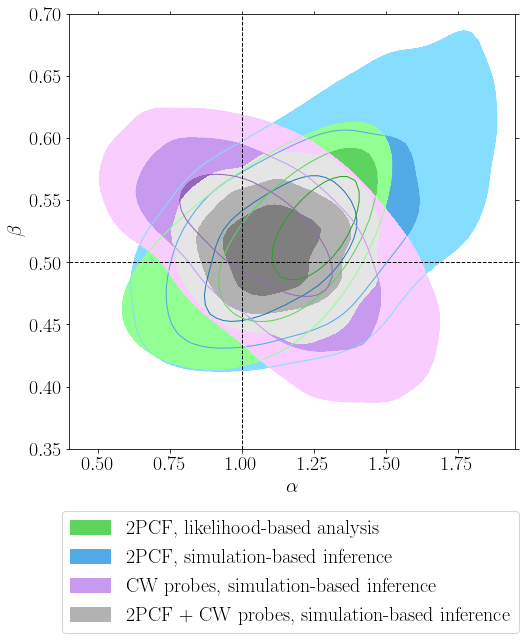

In [19]:
epsilon = 0.05
epsilon_tweb = 0.05
epsilon_comb = 0.05

fig = plt.figure(figsize=(figureWidth,figureWidth))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.tick_params(axis="x",direction="out",bottom=True,top=True)
ax.tick_params(axis="y",direction="out",left=True,right=True)
ax.set_xlim([0.4,1.95])
ax.set_ylim([0.35,0.70])

# Truths
ax.axvline(alpha,lw=1,ls="--",color="k",zorder=5)
ax.axhline(beta,lw=1,ls="--",color="k",zorder=5)

# Contours
ax.contourf(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))
ax.contourf(alphas_tweb, betas_tweb, tweb_lnL[epsilon_tweb], confLevels_grid, colors=np.flip(colors[4]))
ax.contourf(alphas_comb, betas_comb, comb_lnL[epsilon_comb], confLevels_grid, colors=np.flip(colors[7]))
ax.contour(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
ax.contour(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]), linewidths=1.)
ax.contour(alphas_tweb, betas_tweb, tweb_lnL[epsilon_tweb], confLevels_grid, colors=np.flip(colors[4]), linewidths=1.)

# Legend
patch1 = mpatches.Patch(color=colors[2][1], label='2PCF, likelihood-based analysis')
patch2 = mpatches.Patch(color=colors[0][1], label='2PCF, simulation-based inference')
patch3 = mpatches.Patch(color=colors[4][1], label='CW probes, simulation-based inference')
patch4 = mpatches.Patch(color=colors[7][1], label='2PCF + CW probes, simulation-based inference')
plt.legend(handles=[patch1,patch2,patch3,patch4],bbox_to_anchor=(1.03, -0.12))

plt.savefig(fileout+'_posterior_sbi_tweb_'+str(nfields)+'fields.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_posterior_sbi_tweb_'+str(nfields)+'fields.png',dpi=100,bbox_inches="tight")

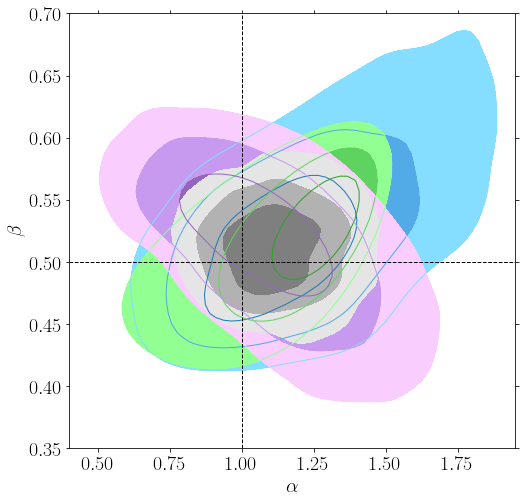

In [20]:
epsilon = 0.05
epsilon_tweb = 0.05
epsilon_comb = 0.05

fig = plt.figure(figsize=(figureWidth,figureWidth))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.tick_params(axis="x",direction="out",bottom=True,top=True)
ax.tick_params(axis="y",direction="out",left=True,right=True)
ax.set_xlim([0.4,1.95])
ax.set_ylim([0.35,0.70])

# Truths
ax.axvline(alpha,lw=1,ls="--",color="k",zorder=5)
ax.axhline(beta,lw=1,ls="--",color="k",zorder=5)

# Contours
ax.contourf(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))
ax.contourf(alphas_tweb, betas_tweb, tweb_lnL[epsilon_tweb], confLevels_grid, colors=np.flip(colors[4]))
ax.contourf(alphas_comb, betas_comb, comb_lnL[epsilon_comb], confLevels_grid, colors=np.flip(colors[7]))
ax.contour(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
ax.contour(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]), linewidths=1.)
ax.contour(alphas_tweb, betas_tweb, tweb_lnL[epsilon_tweb], confLevels_grid, colors=np.flip(colors[4]), linewidths=1.)

# Legend
# patch1 = mpatches.Patch(color=colors[2][1], label='2PCF, likelihood-based analysis')
# patch2 = mpatches.Patch(color=colors[0][1], label='2PCF, simulation-based inference')
# patch3 = mpatches.Patch(color=colors[4][1], label='CW probes, simulation-based inference')
# patch4 = mpatches.Patch(color=colors[7][1], label='2PCF + CW probes, simulation-based inference')
# plt.legend(handles=[patch1,patch2,patch3,patch4],bbox_to_anchor=(1.03, -0.12))

plt.savefig(fileout+'_posterior_sbi_tweb_'+str(nfields)+'fields_nolegend.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_posterior_sbi_tweb_'+str(nfields)+'fields_nolegend.png',dpi=100,bbox_inches="tight")

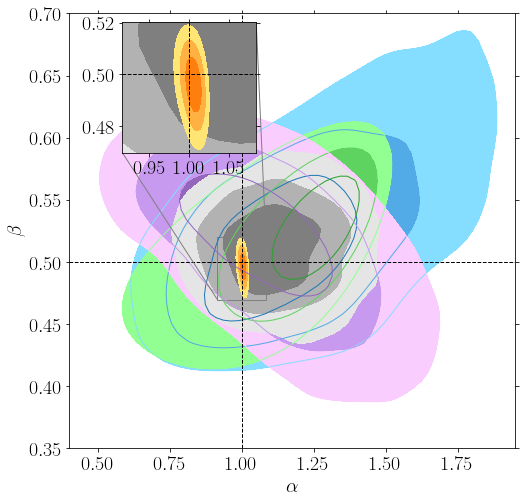

In [21]:
epsilon = 0.05

fig = plt.figure(figsize=(figureWidth,figureWidth))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.tick_params(axis="x",direction="out",bottom=True,top=True)
ax.tick_params(axis="y",direction="out",left=True,right=True)
ax.set_xlim([0.4,1.95])
ax.set_ylim([0.35,0.70])

# Truths
ax.axvline(alpha,lw=1,ls="--",color="k",zorder=5)
ax.axhline(beta,lw=1,ls="--",color="k",zorder=5)

# Contours
ax.contourf(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))
ax.contourf(alphas_tweb, betas_tweb, tweb_lnL[epsilon_tweb], confLevels_grid, colors=np.flip(colors[4]))
ax.contourf(alphas_comb, betas_comb, comb_lnL[epsilon_comb], confLevels_grid, colors=np.flip(colors[7]))
ax.contourf(alphas_da, betas_da, da_lnL, confLevels_grid, colors=np.flip(colors[1]))
ax.contour(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
ax.contour(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]), linewidths=1.)
ax.contour(alphas_tweb, betas_tweb, tweb_lnL[epsilon_tweb], confLevels_grid, colors=np.flip(colors[4]), linewidths=1.)

inset_size = 0.042
axb=fig.add_axes([0,0,1,1], label="ax0b")
ip=InsetPosition(ax, [0.12,0.68,0.3,0.3])
axb.set_axes_locator(ip)
axb.tick_params(axis="x",direction="out",bottom=True,top=True)
axb.tick_params(axis="y",direction="out",left=True,right=True)
alphamean, betamean = 1., 0.495
axb.set_xlim([alphamean-inset_size*(alphamax-alphamin),alphamean+inset_size*(alphamax-alphamin)])
axb.set_ylim([betamean-inset_size*(betamax-betamin),betamean+inset_size*(betamax-betamin)])
axb.axvline(alpha,lw=1,ls="--",color="k")
axb.axhline(beta,lw=1,ls="--",color="k")
axb.contourf(alphas_comb, betas_comb, comb_lnL[epsilon_comb], confLevels_grid, colors=np.flip(colors[7]))
axb.contourf(alphas_da, betas_da, da_lnL, confLevels_grid, colors=np.flip(colors[1]))
mark_inset(ax, axb, loc1=1, loc2=3, fc="none", ec="0.5", ls=None)

# Legend 1
# patch1 = mpatches.Patch(color=colors[2][1], label='2PCF, likelihood-based analysis')
# patch2 = mpatches.Patch(color=colors[0][1], label='2PCF, simulation-based inference')
# plt.legend(handles=[patch1,patch2],bbox_to_anchor=(1.03, -0.12))

# # Legend 2
# patchlist = []
# patchlist.append([mpatches.Patch(color=colors[2][i]) for i in range(3)])
# patchlist.append([mpatches.Patch(color=colors[0][i]) for i in range(3)])
# patchlist.append([mpatches.Patch(color=colors[1][i]) for i in range(3)])
# categories = ['2PCF, likelihood-based analysis', '2PCF, simulation-based inference ($\\varepsilon='+str(epsilon)+'$)', 'Full field, data assimilation']
# plt.legend(handles=patchlist, labels=categories, handler_map = {list: HandlerTuple(None)}, loc='lower left')

plt.savefig(fileout+'_posterior_sbi_tweb_da_'+str(nfields)+'fields_comb_nolegend.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_posterior_sbi_tweb_da_'+str(nfields)+'fields_comb_nolegend.png',dpi=100,bbox_inches="tight")

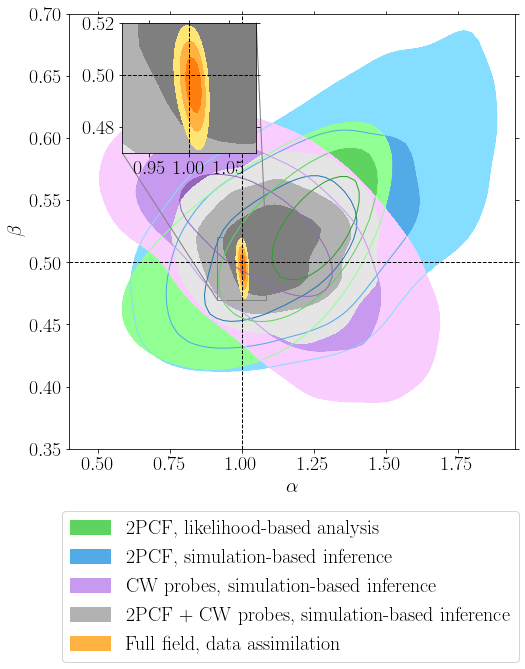

In [22]:
epsilon = 0.05

fig = plt.figure(figsize=(figureWidth,figureWidth))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.tick_params(axis="x",direction="out",bottom=True,top=True)
ax.tick_params(axis="y",direction="out",left=True,right=True)
ax.set_xlim([0.4,1.95])
ax.set_ylim([0.35,0.70])

# Truths
ax.axvline(alpha,lw=1,ls="--",color="k",zorder=5)
ax.axhline(beta,lw=1,ls="--",color="k",zorder=5)

# Contours
ax.contourf(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax.contourf(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]))
ax.contourf(alphas_tweb, betas_tweb, tweb_lnL[epsilon_tweb], confLevels_grid, colors=np.flip(colors[4]))
ax.contourf(alphas_comb, betas_comb, comb_lnL[epsilon_comb], confLevels_grid, colors=np.flip(colors[7]))
ax.contourf(alphas_da, betas_da, da_lnL, confLevels_grid, colors=np.flip(colors[1]))
ax.contour(alphas_sbi, betas_sbi, sbi_lnL[epsilon], confLevels_grid, colors=np.flip(colors[0]), linewidths=1.)
ax.contour(alphas_sum, betas_sum, sum_lnL, confLevels_grid, colors=np.flip(colors[2]), linewidths=1.)
ax.contour(alphas_tweb, betas_tweb, tweb_lnL[epsilon_tweb], confLevels_grid, colors=np.flip(colors[4]), linewidths=1.)

inset_size = 0.042
axb=fig.add_axes([0,0,1,1], label="ax0b")
ip=InsetPosition(ax, [0.12,0.68,0.3,0.3])
axb.set_axes_locator(ip)
axb.tick_params(axis="x",direction="out",bottom=True,top=True)
axb.tick_params(axis="y",direction="out",left=True,right=True)
alphamean, betamean = 1., 0.495
axb.set_xlim([alphamean-inset_size*(alphamax-alphamin),alphamean+inset_size*(alphamax-alphamin)])
axb.set_ylim([betamean-inset_size*(betamax-betamin),betamean+inset_size*(betamax-betamin)])
axb.axvline(alpha,lw=1,ls="--",color="k")
axb.axhline(beta,lw=1,ls="--",color="k")
axb.contourf(alphas_comb, betas_comb, comb_lnL[epsilon_comb], confLevels_grid, colors=np.flip(colors[7]))
axb.contourf(alphas_da, betas_da, da_lnL, confLevels_grid, colors=np.flip(colors[1]))
mark_inset(ax, axb, loc1=1, loc2=3, fc="none", ec="0.5", ls=None)

# Legend
patch1 = mpatches.Patch(color=colors[2][1], label='2PCF, likelihood-based analysis')
patch2 = mpatches.Patch(color=colors[0][1], label='2PCF, simulation-based inference')
patch3 = mpatches.Patch(color=colors[4][1], label='CW probes, simulation-based inference')
patch4 = mpatches.Patch(color=colors[7][1], label='2PCF + CW probes, simulation-based inference')
patch5 = mpatches.Patch(color=colors[1][1], label='Full field, data assimilation')
ax.legend(handles=[patch1,patch2,patch3,patch4,patch5],bbox_to_anchor=(1.03, -0.12))

plt.savefig(fileout+'_posterior_sbi_tweb_da_'+str(nfields)+'fields_comb.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_posterior_sbi_tweb_da_'+str(nfields)+'fields_comb.png',dpi=100,bbox_inches="tight")

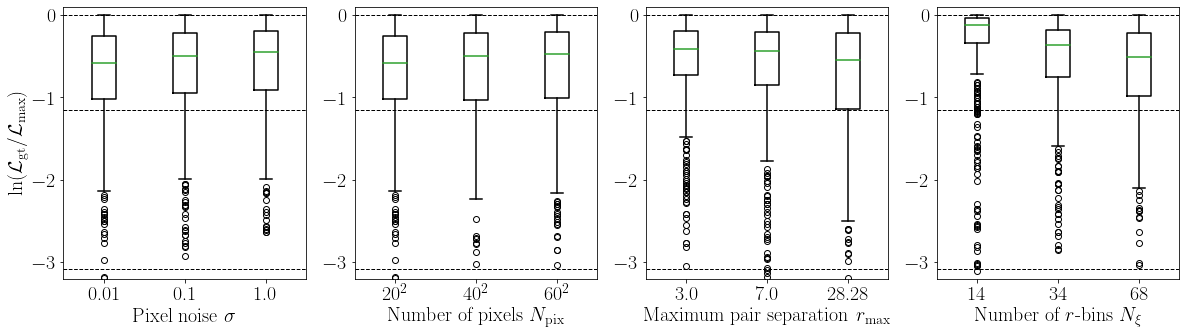

In [23]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20,5))
ax0.set_ylim([-3.2,0.1])
ax0.set_xlabel("Pixel noise $\sigma$")
ax0.set_ylabel("$\ln( \mathcal{L}_\mathrm{gt}/\mathcal{L}_\mathrm{max} )$")
for i in range(len(contour_levels)):
    ax0.axhline(contour_levels[i],ls="--",lw=1,color="k")
PixelNoises = np.unique(np.array(list(lnLgt_PixelNoise.keys())).T[0])
data = [[lnLgt_PixelNoise[PixelNoise,i] for i in range(nsims)] for PixelNoise in PixelNoises]
ax0.boxplot(data, boxprops=dict(color='black',lw=1.5), medianprops=dict(color='C2',lw=1.5), capprops=dict(lw=1.5), whiskerprops=dict(lw=1.5), flierprops=dict(lw=1.5))
ax0.set_xticklabels(PixelNoises)

ax1.set_ylim([-3.2,0.1])
ax1.set_xlabel("Number of pixels $N_\mathrm{pix}$")
for i in range(len(contour_levels)):
    ax1.axhline(contour_levels[i],ls="--",lw=1,color="k")
Lsides = np.unique(np.array(list(lnLgt_Lside.keys())).T[0])
data = [[lnLgt_Lside[Lside,i] for i in range(nsims)] for Lside in Lsides]
ax1.boxplot(data, boxprops=dict(color='black',lw=1.5), medianprops=dict(color='C2',lw=1.5), capprops=dict(lw=1.5), whiskerprops=dict(lw=1.5), flierprops=dict(lw=1.5))
ax1.set_xticklabels(["$20^2$", "$40^2$", "$60^2$"])

ax2.set_ylim([-3.2,0.1])
ax2.set_xlabel("Maximum pair separation $r_\mathrm{max}$")
for i in range(len(contour_levels)):
    ax2.axhline(contour_levels[i],ls="--",lw=1,color="k")
rmaxs = np.unique(np.array(list(lnLgt_rmax.keys())).T[0])
data = [[lnLgt_rmax[rmax,i] for i in range(nsims)] for rmax in rmaxs]
ax2.boxplot(data, boxprops=dict(color='black',lw=1.5), medianprops=dict(color='C2',lw=1.5), capprops=dict(lw=1.5), whiskerprops=dict(lw=1.5), flierprops=dict(lw=1.5))
rmaxs[-1]=28.28
ax2.set_xticklabels(rmaxs)

ax3.set_ylim([-3.2,0.1])
ax3.set_xlabel("Number of $r$-bins $N_{\\xi}$")
for i in range(len(contour_levels)):
    ax3.axhline(contour_levels[i],ls="--",lw=1,color="k")
nbins = np.unique(np.array(list(lnLgt_nbin.keys())).T[0])
data = [[lnLgt_nbin[nbin,i] for i in range(nsims)] for nbin in nbins]
ax3.boxplot(data, boxprops=dict(color='black',lw=1.5), medianprops=dict(color='C2',lw=1.5), capprops=dict(lw=1.5), whiskerprops=dict(lw=1.5), flierprops=dict(lw=1.5))
ax3.set_xticklabels(nbins)

plt.savefig(fileout+'_dependence_lba.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_dependence_lba.png',dpi=100,bbox_inches="tight")

In [24]:
%run config_02.py

Figures saved at figures/Output20_05_02_80_80_500_80_1_123457
Simulations saved at data/Sims20_05_02_80_80_500_80_1_123457


In [25]:
## Load data ##
# ----------- #

lognormfields=np.load(simsout+'.npy')
T=np.load(dataout+'_mean_cov_theory.npz')
average_r, mean2pt, cov, xiLN = T['average_r'], T['mean2pt'], T['cov'], T['xiLN']
dxiLN_dalpha, dxiLN_dbeta = T['dxiLN_dalpha'], T['dxiLN_dbeta']

nfields = 4

# Simulation pool
P=np.load(dataout+'_sbi_pool.npz')
alpha_pool, beta_pool, comp_pool = P['alpha_pool'], P['beta_pool'], P['comp_pool']

# 2PCF, simulation-based inference
sample_size, alpha_marginal_stds, beta_marginal_stds = {}, {}, {}
sbi_samples, sbi_weights, disc_samples = {}, {}, {}
alpha_samples, beta_samples = {}, {}

for f in range(nfields):
    A=np.load(dataout+'_sbi_field'+str(f)+'.npz')
    epsilons, sample_size[f], alpha_marginal_stds[f], beta_marginal_stds[f] = \
        A['epsilons'], A['sample_size'], A['alpha_marginal_stds'], A['beta_marginal_stds']

    for epsilon in epsilons:
        AA=np.load(dataout+'_sbi_field'+str(f)+'_eps'+str(int(100*epsilon))+'_samples_posterior.npz')
        sbi_samples[f,epsilon], sbi_weights[f,epsilon], disc_samples[f,epsilon] = AA['samples'], AA['weights'], AA['disc']
        alpha_samples[f,epsilon], beta_samples[f,epsilon] = sbi_samples[f,epsilon].T[0], sbi_samples[f,epsilon].T[1]

sbi_lnL0, sbi_lnL1, sbi_lnL2, sbi_lnL3, sbi_lnL = {}, {}, {}, {}, {}
for epsilon in epsilons:
    with np.load(dataout+'_sbi_eps'+str(int(100*epsilon))+'_'+str(nfields)+'fields.npz') as C:
        sbi_lnL0[epsilon] = C['lnL0']
        sbi_lnL1[epsilon] = C['lnL1']
        sbi_lnL2[epsilon] = C['lnL2']
        sbi_lnL3[epsilon] = C['lnL3']
        sbi_lnL[epsilon] = C['lnL']
        alphas_sbi, betas_sbi = C['alphas'], C['betas']

# 2PCF, likelihood-based analysis
with np.load(dataout+'_summaries_'+str(nfields)+'fields.npz') as B:
    alphas_sum, betas_sum, sum_lnL0, sum_lnL1, sum_lnL2, sum_lnL3, sum_lnL =\
        B['alphas'], B['betas'], B['lnL0'], B['lnL1'], B['lnL2'], B['lnL3'], B['lnL']

# Full field, data assimilation
nfields_da = 2
da_samples, da_weights = {}, {}
for f in range(nfields_da):
    D = np.load(dataout+'_da_'+str(f)+'.npz')
    da_samples, da_weights = D['samples'], D['weights']
with np.load(dataout+'_da_kde.npz') as DD:
    alphas_da, betas_da, da_lnL0, da_lnL1, da_lnL =\
        DD['alphas'], DD['betas'], DD['lnL0'], DD['lnL1'], DD['lnL']

field_data, field_posterior_mean, field_difference, field_rhat = {}, {}, {}, {}

for f in range(nfields_da):
    with np.load('data/Data20_05_10_80_80_500_80_1_123456_da_fields_'+str(f)+'.npz') as F:
        field_data[f], field_posterior_mean[f], field_difference[f], field_rhat[f] = F['data'], F['posterior_mean'], F['difference'], F['rhat_field']

with np.load('data/Data20_05_02_80_80_500_80_1_123457_da_fields_0.npz') as F5:
    field_data[4] = F5['data']

truths2d = np.expand_dims(np.array([beta,alpha]), axis=0)

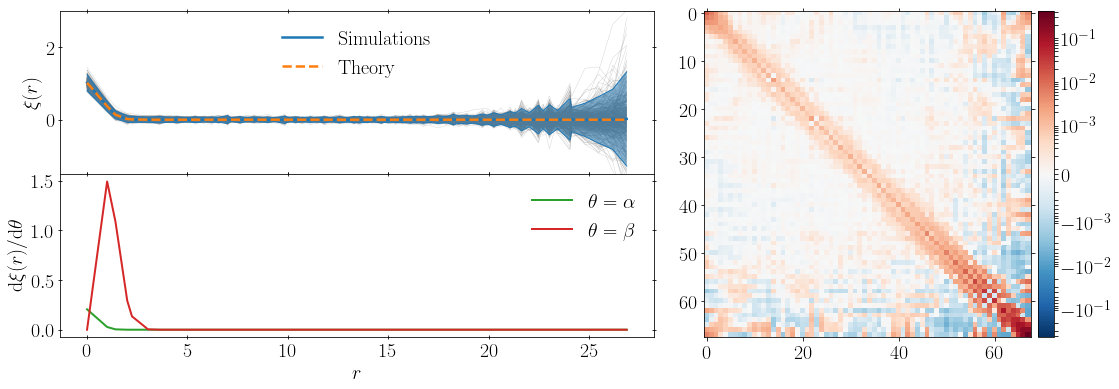

In [26]:
fig = plt.figure(figsize=(20,6))
gs = fig.add_gridspec(2, 2, hspace=0., wspace=-0.12)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_ylabel('$\\xi(r)$')
ax0.set_ylim([-1.5,3])
ax0.tick_params(axis="x",direction="inout",bottom=True,top=True)
ax0.tick_params(axis="y",direction="inout",left=True,right=True)
plt.setp(ax0.get_xticklabels(), visible=False)

for i in range(nsims):
    ax0.plot(average_r,lognormfields[i]['corrfn'],color="grey",lw=0.5,alpha=0.3,zorder=0.5)

# Plot the mean correlation function:
ax0.plot(average_r,mean2pt,lw=2.5,label="Simulations")

# Plot the diagonal of the covariance matrix.  Wild fluctuations are from varying numbers of pairs per bin
ax0.fill_between(average_r,mean2pt-2*np.sqrt(np.diag(cov)),mean2pt+2*np.sqrt(np.diag(cov)),alpha=0.5)
ax0.plot(average_r,mean2pt-2*np.sqrt(np.diag(cov)),c='C0',lw=1.)
ax0.plot(average_r,mean2pt+2*np.sqrt(np.diag(cov)),c='C0',lw=1.)

# Plot the mean correlation function and the theory with the correct alpha, beta :
ax0.plot(average_r,xiLN,ls='--',lw=2.5,label="Theory")
ax0.legend(loc='best',frameon=False)

ax1 = fig.add_subplot(gs[1,0], sharex=ax0)
ax1.set_xlabel('$r$')
ax1.set_ylabel('$\\mathrm{d}\\xi(r)/\\mathrm{d}\\theta$')
ax1.tick_params(axis="x",direction="inout",bottom=True,top=True)
ax1.tick_params(axis="y",direction="inout",left=True,right=True)

# Plot the gradients
ax1.plot(average_r,dxiLN_dalpha,label="$\\theta=\\alpha$",color='C2')
ax1.plot(average_r,dxiLN_dbeta,label="$\\theta=\\beta$",color='C3')
ax1.legend(loc='best',frameon=False)

# Plot the covariance matrix
ax2 = fig.add_subplot(gs[:,-1])
ax2.tick_params(axis="x",direction="out",bottom=True,top=True)
ax2.tick_params(axis="y",direction="out",left=True,right=True)

im2 = ax2.pcolormesh(np.arange(cov.shape[0]), np.arange(cov.shape[1]), cov,
                       norm=mcolors.SymLogNorm(linthresh=1e-4, linscale=0.1,
                                              vmin=-cov.max(), vmax=cov.max(), base=10),
                       cmap='RdBu_r', shading='auto')

ax2.invert_yaxis()
ax2.set_aspect('equal')
d2 = make_axes_locatable(ax2)
cax2 = d2.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im2, cax=cax2)
tick_labels=np.array([item.get_text() for item in cbar.ax.get_yticklabels()])
tick_labels=np.where(tick_labels=='$\\mathdefault{10^{-4}}$','',tick_labels)
tick_labels=np.where(tick_labels=='$\\mathdefault{-10^{-4}}$','',tick_labels)
cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels(tick_labels)

plt.savefig(fileout+'_corrfn.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_corrfn.png',dpi=100,bbox_inches="tight")

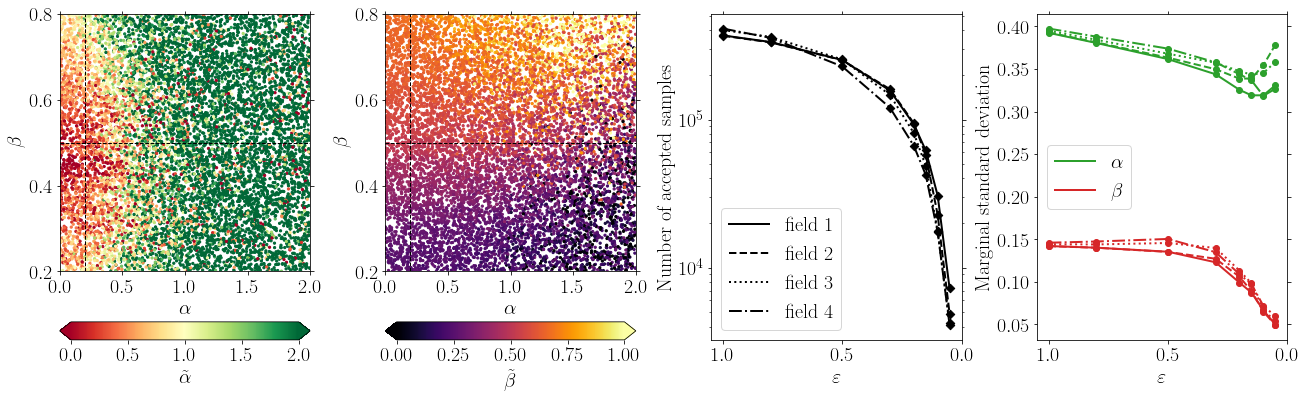

In [27]:
N=10000
fig=plt.figure(figsize=(22,6))

ax0=fig.add_subplot(1,4,1)
ax0.set_xlabel("$\\alpha$")
ax0.set_ylabel("$\\beta$")
ax0.tick_params(axis="x",direction="out",bottom=True,top=True)
ax0.tick_params(axis="y",direction="out",left=True,right=True)
ax0.axvline(alpha,lw=1,ls="--",color="k",zorder=5)
ax0.axhline(beta,lw=1,ls="--",color="k",zorder=5)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
im0 = ax0.scatter(alpha_pool[:N], beta_pool[:N], c=comp_pool[:N].T[0], s=5., vmin=0., vmax=2., cmap="RdYlGn")
ax0_divider = make_axes_locatable(ax0)
cax0 = ax0_divider.append_axes("bottom", size="7%", pad=0.7)
cb0 = fig.colorbar(im0, cax=cax0, orientation="horizontal", extend="both")
cb0.ax.set_xlabel("$\\tilde{\\alpha}$")

ax1=fig.add_subplot(1,4,2)
ax1.set_xlabel("$\\alpha$")
ax1.set_ylabel("$\\beta$")
ax1.tick_params(axis="x",direction="out",bottom=True,top=True)
ax1.tick_params(axis="y",direction="out",left=True,right=True)
ax1.axvline(alpha,lw=1,ls="--",color="k",zorder=5)
ax1.axhline(beta,lw=1,ls="--",color="k",zorder=5)
ax1.set_xlim([alphamin,alphamax])
ax1.set_ylim([betamin,betamax])
im1 = ax1.scatter(alpha_pool[:N], beta_pool[:N], c=comp_pool[:N].T[1], s=5., vmin=0., vmax=1., cmap="inferno")
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("bottom", size="7%", pad=0.7)
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", extend="both")
cb1.ax.set_xlabel("$\\tilde{\\beta}$")

ax2=fig.add_subplot(1,4,3)
ax2.set_xlim([1.05,0])
ax2.tick_params(which="both",axis="x",direction="out",bottom=True,top=True)
ax2.tick_params(which="both",axis="y",direction="out",left=True,right=True)
ax2.set_xlabel("$\\varepsilon$")
ax2.set_ylabel("Number of accepted samples")
for f in range(nfields):
    ax2.scatter(epsilons,sample_size[f],marker='D',color='k')
ax2.semilogy(epsilons,sample_size[0],ls='-',color='k',label="field 1")
ax2.semilogy(epsilons,sample_size[1],ls='--',color='k',label="field 2")
ax2.semilogy(epsilons,sample_size[2],ls=':',color='k',label="field 3")
ax2.semilogy(epsilons,sample_size[3],ls='-.',color='k',label="field 4")
ax2.legend(loc="lower left")

ax3=fig.add_subplot(1,4,4)
ax3.set_xlim([1.05,0])
ax3.tick_params(axis="x",direction="out",bottom=True,top=True)
ax3.tick_params(axis="y",direction="out",left=True,right=True)
ax3.set_xlabel("$\\varepsilon$")
ax3.set_ylabel("Marginal standard deviation")
for f in range(nfields):
    ax3.scatter(epsilons,alpha_marginal_stds[f],marker='o',color='C2')
    ax3.scatter(epsilons,beta_marginal_stds[f],marker='o',color='C3')
ax3.plot(epsilons,alpha_marginal_stds[0],ls='-',color='C2',label='$\\alpha$')
ax3.plot(epsilons,beta_marginal_stds[0],ls='-',color='C3',label='$\\beta$')
ax3.plot(epsilons,alpha_marginal_stds[1],ls='--',color='C2')
ax3.plot(epsilons,beta_marginal_stds[1],ls='--',color='C3')
ax3.plot(epsilons,alpha_marginal_stds[2],ls=':',color='C2')
ax3.plot(epsilons,beta_marginal_stds[2],ls=':',color='C3',)
ax3.plot(epsilons,alpha_marginal_stds[3],ls='-.',color='C2')
ax3.plot(epsilons,beta_marginal_stds[3],ls='-.',color='C3')
ax3.legend(loc="center left")

plt.subplots_adjust(wspace=0.30)
plt.savefig(fileout+'_simulations.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_simulations.png',dpi=100,bbox_inches="tight")

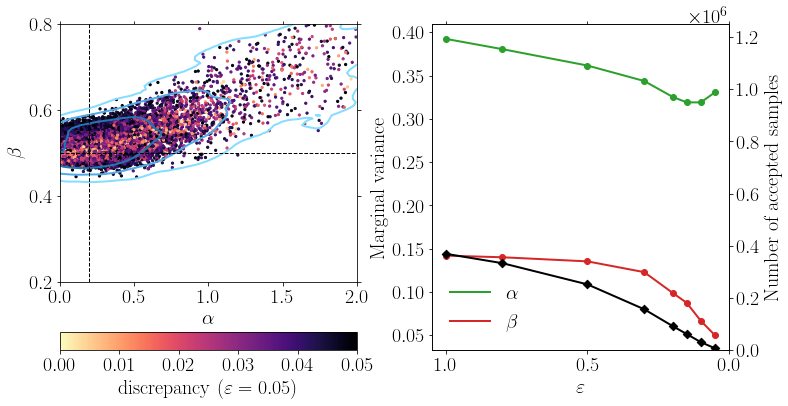

In [28]:
f=0
epsilon=0.05
N=10000
fig=plt.figure(figsize=(12,6))

ax0=fig.add_subplot(1,2,1)
ax0.set_xlabel("$\\alpha$")
ax0.set_ylabel("$\\beta$")
ax0.tick_params(axis="x",direction="out",bottom=True,top=True)
ax0.tick_params(axis="y",direction="out",left=True,right=True)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
ax0.axvline(alpha,lw=1,ls="--",color="k",zorder=5)
ax0.axhline(beta,lw=1,ls="--",color="k",zorder=5)
im0 = ax0.scatter(alpha_samples[f,epsilon][:N], beta_samples[f,epsilon][:N], c=disc_samples[f,epsilon][:N], s=5., vmin=0, vmax=0.05, cmap='magma_r')
ax0.contour(alphas_sbi, betas_sbi, sbi_lnL0[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax0_divider = make_axes_locatable(ax0)
cax0 = ax0_divider.append_axes("bottom", size="7%", pad=0.7)
cb0 = fig.colorbar(im0, cax=cax0, orientation="horizontal")
cb0.set_ticks([0,0.01,0.02,0.03,0.04,0.05])
cb0.ax.set_xlabel("discrepancy ($\\varepsilon=0.05$)")

ax1=fig.add_subplot(1,2,2)
ax1.set_xlim([1.05,0])
ax1.tick_params(axis="x",direction="out",bottom=True,top=True)
ax1.set_xlabel("$\\varepsilon$")
ax1.set_ylabel("Marginal variance")
ax1.scatter(epsilons,alpha_marginal_stds[f],marker='o',color='C2')
ax1.plot(epsilons,alpha_marginal_stds[f],color='C2',label='$\\alpha$')
ax1.scatter(epsilons,beta_marginal_stds[f],marker='o',color='C3')
ax1.plot(epsilons,beta_marginal_stds[f],color='C3',label="$\\beta$")

ax2=ax1.twinx()
ax2.set_ylim(0,1.25e6)
ax2.set_ylabel("Number of accepted samples")
ax2.scatter(epsilons,sample_size[f],marker='D',color='k')
ax2.plot(epsilons,sample_size[f],color='k')

ax1.legend(loc="best",frameon=False)

plt.subplots_adjust(wspace=0.25)
plt.savefig(fileout+'_sbi.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_sbi.png',dpi=100,bbox_inches="tight")

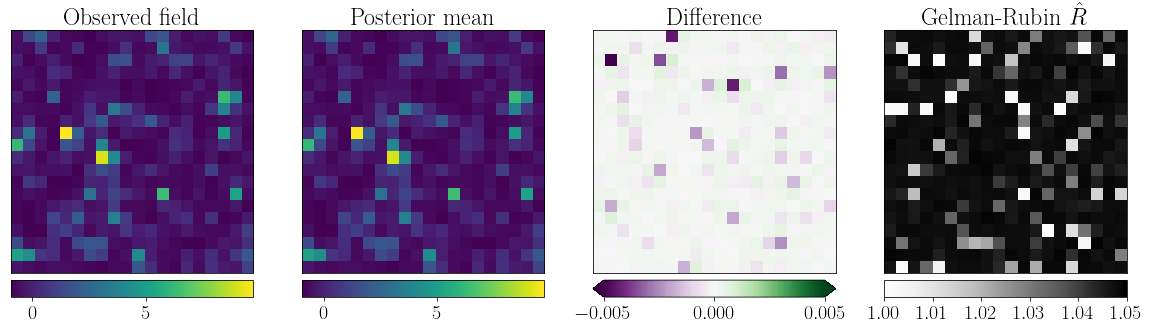

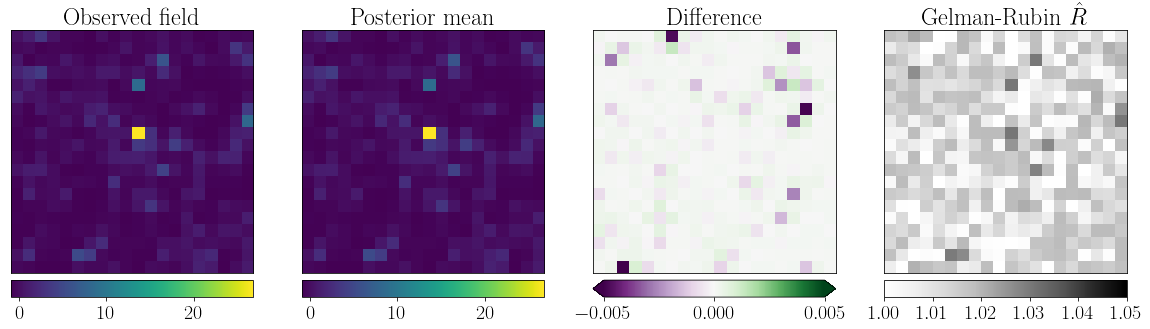

In [29]:
for f in range(nfields_da):
    vmin=np.min((field_data[f].min(),field_posterior_mean[f].min()))
    vmax=np.max((field_data[f].max(),field_posterior_mean[f].max()))

    fig=plt.figure(figsize=(20,6))
    ax0=fig.add_subplot(1,4,1)
    ax0.set_xticks([])
    ax0.set_yticks([])
    im0 = ax0.imshow(field_data[f], cmap='viridis', vmin=vmin, vmax=vmax)
    ax0.set_title("Observed field")
    ax0_divider = make_axes_locatable(ax0)
    cax0 = ax0_divider.append_axes("bottom", size="7%", pad=0.1)
    cb0 = fig.colorbar(im0, cax=cax0, orientation="horizontal")

    ax1=fig.add_subplot(1,4,2)
    ax1.set_xticks([])
    ax1.set_yticks([])
    im1 = ax1.imshow(field_posterior_mean[f], cmap='viridis',  vmin=vmin, vmax=vmax)
    ax1.set_title("Posterior mean")
    ax1_divider = make_axes_locatable(ax1)
    cax1 = ax1_divider.append_axes("bottom", size="7%", pad=0.1)
    cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal")

    ax2=fig.add_subplot(1,4,3)
    ax2.set_xticks([])
    ax2.set_yticks([])
    im2 = ax2.imshow(field_difference[f], cmap='PRGn', vmin=-0.005, vmax=0.005)
    ax2.set_title("Difference")
    ax2_divider = make_axes_locatable(ax2)
    cax2 = ax2_divider.append_axes("bottom", size="7%", pad=0.1)
    cb2 = fig.colorbar(im2, cax=cax2, orientation="horizontal", extend='both')
    cb2.set_ticks([-0.005,0.,0.005])

    ax3=fig.add_subplot(1,4,4)
    ax3.set_xticks([])
    ax3.set_yticks([])
    im3 = ax3.imshow(field_rhat[f], cmap='Greys', vmin=1., vmax=1.05)
    ax3.set_title("Gelman-Rubin $\\hat{R}$")
    ax3_divider = make_axes_locatable(ax3)
    cax3 = ax3_divider.append_axes("bottom", size="7%", pad=0.1)
    cb3 = fig.colorbar(im3, cax=cax3, orientation="horizontal")
    cb3.set_ticks([1,1.01,1.02,1.03,1.04,1.05])

    plt.savefig(fileout+'_field_posterior_'+str(f)+'.pdf',dpi=300,bbox_inches="tight",transparent=True)
    plt.savefig(fileout+'_field_posterior_'+str(f)+'.png',dpi=100,bbox_inches="tight")

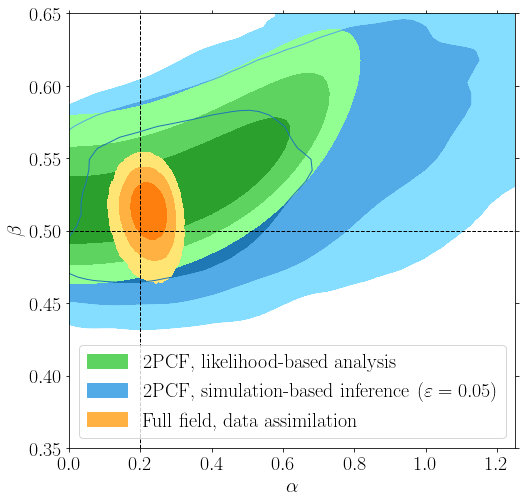

In [30]:
f=0
epsilon=0.05

fig = plt.figure(figsize=(figureWidth,figureWidth))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.tick_params(axis="x",direction="out",bottom=True,top=True)
ax.tick_params(axis="y",direction="out",left=True,right=True)
ax.set_xlim([0.00,1.25])
ax.set_ylim([0.35,0.65])

# Truths
ax.axvline(alpha,lw=1,ls="--",color="k",zorder=5)
ax.axhline(beta,lw=1,ls="--",color="k",zorder=5)

# SBI
# ax = plot2d(ax, 1, [sbi_samples.T], [sbi_weights.T], nBins, smoothingKernel,
#             filledPlots, [colorsDict['blues']], nContourLevels, confLevels, truths2d,
#             truthColors, truthLineStyles, plotDensity, myColorMap)
ax.contourf(alphas_sbi, betas_sbi, sbi_lnL0[epsilon], confLevels_grid, colors=np.flip(colors[0]))
ax.contour(alphas_sbi, betas_sbi, sbi_lnL0[epsilon], confLevels_grid, colors=np.flip(colors[0]),linewidths=1)

# Summaries
ax.contourf(alphas_sum, betas_sum, sum_lnL0, confLevels_grid, colors=np.flip(colors[2]))

# DA
# ax = plot2d(ax, 1, [da_samples.T], [da_weights.T], nBins, smoothingKernel,
#             filledPlots, [colorsDict['oranges']], nContourLevels, confLevels, truths2d,
#             truthColors, truthLineStyles, plotDensity, myColorMap)
ax.contourf(alphas_da, betas_da, da_lnL0, confLevels_grid, colors=np.flip(colors[1]))

# Legend 1
patch1 = mpatches.Patch(color=colors[2][1], label='2PCF, likelihood-based analysis')
patch2 = mpatches.Patch(color=colors[0][1], label='2PCF, simulation-based inference ($\\varepsilon='+str(epsilon)+'$)')
patch3 = mpatches.Patch(color=colors[1][1], label='Full field, data assimilation')
plt.legend(handles=[patch1,patch2],loc='lower left')
plt.legend(handles=[patch1,patch2,patch3],loc='lower left')

# # Legend 2
# patchlist = []
# patchlist.append([mpatches.Patch(color=colors[2][i]) for i in range(3)])
# patchlist.append([mpatches.Patch(color=colors[0][i]) for i in range(3)])
# patchlist.append([mpatches.Patch(color=colors[1][i]) for i in range(3)])
# categories = ['2PCF, likelihood-based analysis', '2PCF, simulation-based inference ($\\varepsilon='+str(epsilon)+'$)', 'Full field, data assimilation']
# plt.legend(handles=patchlist, labels=categories, handler_map = {list: HandlerTuple(None)}, loc='lower left')

plt.savefig(fileout+'_posterior_sbi_da.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(fileout+'_posterior_sbi_da.png',dpi=100,bbox_inches="tight")